### First, we'll load in the processed data from the data folder

In [1]:
import numpy as np
import pandas as pd

X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv')
X_val = pd.read_csv('../data/X_val.csv')
y_val = pd.read_csv('../data/y_val.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [2]:
X_train

Open      High       Low     Close    Volume  moving_avg_50  \
0   -1.261893 -1.282373 -1.244264 -1.257836 -1.043700            NaN   
1   -1.264133 -1.269703 -1.274461 -1.305309 -0.313123      -1.218345   
2   -1.303205 -1.313705 -1.312510 -1.337888  0.035411      -1.243204   
3   -1.327979 -1.263471 -1.292745 -1.235772  0.181478      -1.262864   
4   -1.231848 -1.231140 -1.210141 -1.203882 -0.035195      -1.245957   
..        ...       ...       ...       ...       ...            ...   
748  1.875767  1.879728  1.880024  1.869527 -0.367313       1.862093   
749  1.867188  1.860309  1.885052  1.865527 -0.313181       1.870502   
750  1.894373  1.889369  1.891904  1.872699 -0.030484       1.878092   
751  1.851855  1.820232  1.762988  1.790303 -0.176766       1.882102   
752  1.793935  1.785319  1.712613  1.735004 -0.417883       1.885578   

     moving_avg_100       Day  Days_to_election  Avg_month_temp  ...  Month_3  \
0               NaN  0.779614          1.000000        0.159902  ...      0.0   
1         -1.177777  0.782369          0.999082        0.159902  ...      0.0   
2         -1.203765  0.785124          0.998163        0.159902  ...      0.0   
3         -1.224317  0.787879          0.997245        0.159902  ...      0.0   
4         -1.206643  0.790634          0.996327        0.159902  ...      0.0   
..              ...       ...               ...             ...  ...      ...   
748        1.817391  0.749311          0.003673       -0.082026  ...      0.0   
749        1.824953  0.752066          0.002755       -0.082026  ...      0.0   
750        1.832419  0.754821          0.001837       -0.082026  ...      0.0   
751        1.838891  0.757576          0.000918       -0.082026  ...      0.0   
752        1.845464  0.760331          0.000000       -0.082026  ...      0.0   

     Month_4  Month_5  Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  \
0        0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
1        0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
2        0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
3        0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
4        0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
..       ...      ...      ...      ...      ...      ...       ...       ...   
748      0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
749      0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
750      0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
751      0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
752      0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   

     Month_12  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
..        ...  
748       0.0  
749       0.0  
750       0.0  
751       0.0  
752       0.0  

[753 rows x 25 columns]

## Processing: 14-day sliding prediction window
***Our model will predict values of our target variable by considering the past two weeks' data at any time. In order to do this, we will transform the stucture of our data such that each row includes a given day's feature values, as well as the values for each of the 14 preceeding days. We will also include the past values of the target variable in this window because after a day has passed, the target variable's value on that day can be treated as known.***

In [3]:
# each column will have a '_i' at the end of its name indicating
# its delay (i.e. the present day will end in '_0' and the values
# from two weeks ago will have '_14' at the end).

def get_lagged_df(df, delay):
    '''function to take in a dataframe return a df with lagged columns'''
    # list for all of the shifted df copies that we'll concat into the df
    values = []
    # shift by value i=0,...,delay so we have the original day's value
    # as well as its window
    for i in range(delay+1):
        values.append(df.shift(i).copy())
        values[-1].columns = [col + '_' + str(i) for col in df.columns]
    return pd.concat(values, axis=1)

In [4]:
# now lets go through our target variable and grab the lagged values for that
# --> just as in the previous method we'll add on target variable columns for
# delays i=1,...,14 (not 0 because we aren't allowed to see the current day's
# target value)

# function will take in the df we're editing along with the corresponding
# target variable series y

def get_lagged_y(df, y, delay):
    '''take in lagged feature matrix, attach lagged y values'''
    for i in range(delay):
        df['y_'+str(i+1)] = y.shift(i+1)
    return df

In [5]:
# function to combine the two lagging methods and spit out our data in the form 
# in which we can feed it to a regression model

def get_timeseries_df(df, y, delay):
    '''wrapper method to do both steps in one call'''
    df = get_lagged_df(df, delay)
    df = get_lagged_y(df, y, delay)
    return df

### Now we can transform our data to be windowed for 14-day sliding time series window

In [66]:
# generating the datasets
X_train_windowed = get_timeseries_df(X_train, y_train, 14)
X_val_windowed = get_timeseries_df(X_val, y_val, 14)
X_test_windowed = get_timeseries_df(X_test, y_test, 14)

In [68]:
# check for current day features that give us unfair information about the adj. close price
# i.e. get rid of any current day information that wouldn't be available at market open
for col in X_train_windowed.columns:
    if col.endswith('_0'):
        print(col)
        

Open_0
High_0
Low_0
Close_0
Volume_0
moving_avg_50_0
moving_avg_100_0
Day_0
Days_to_election_0
Avg_month_temp_0
Avg_month_temp_dev_0
CCI_0
VIXCLS_0
Month_1_0
Month_2_0
Month_3_0
Month_4_0
Month_5_0
Month_6_0
Month_7_0
Month_8_0
Month_9_0
Month_10_0
Month_11_0
Month_12_0


In [69]:
# From the check above, will get rid of all non-date features expect for Open_0
cols_to_remv = ['High_0', 'Low_0', 'Close_0', 'Volume_0', 'moving_avg_50_0',
               'moving_avg_100_0', 'Avg_month_temp_0', 'Avg_month_temp_dev_0',
               'CCI_0', 'VIXCLS_0']
X_train_windowed.drop(columns=cols_to_remv, inplace=True)
X_val_windowed.drop(columns=cols_to_remv, inplace=True)
X_test_windowed.drop(columns=cols_to_remv, inplace=True)


In [70]:
# ... and saving them to our data folder
X_train_windowed.to_csv('../data/X_train_windowed.csv', index=False)
X_val_windowed.to_csv('../data/X_val_windowed.csv', index=False)
X_test_windowed.to_csv('../data/X_test_windowed.csv', index=False)


## Random Forest Regressor

***With a random forest we can't extrapolate to unseen target values so we're flatlining in the sections of training data with target values that surpass what was seen in the training and validation steps. To get around this we will change the target variable for the random forest to percent change from one day to the next, and use these values/predictions to reconstruct the adjusted close price values***

-----

***With a random forest we need to drop the missing values, so we'll get rid of the first 14 rows in our data sets***

In [71]:
# drop rows with missing values
X_train_rf = X_train_windowed.dropna()
# get the y values for the corresponding data points
y_train_rf = y_train.iloc[X_train_rf.index]

X_val_rf = X_val_windowed.dropna()
y_val_rf = y_val.iloc[X_val_rf.index]

X_test_rf = X_test_windowed.dropna()
y_test_rf = y_test.iloc[X_test_rf.index]

## Implementation of a persistence model -- this isn't our baseline model but we'll use it time to time for comparison against a naive prediction moel
### ***(Baseline should just be a prediction of the mean y value)***
***This model just predicts the the target value at $t-1$ for $t$, and we'll use RMSE as our metic***

*Below we get a run a quick example on our training data*

In [93]:
# our baseline model that will predict that the value at any time step
# will persist to the next time step

# it just returns the first 1,...,n-1 values of the target variable
# but these are its predictions for times 2,...,n (we won't have a
# prediction for time t=1 under this model)
def persistence_predict(target_series):
    '''function to make the baseline prediction'''
    return target_series[:-1]

# and we can get the RMSE by comparing this to the target values at
# t = 2,...,n
from sklearn.metrics import mean_squared_error

y_persistence_pred = persistence_predict(y_val_rf)
persistence_rmse = mean_squared_error(y_val_rf[1:], y_persistence_pred, squared=False)

print('Baseline persistence model RMSE on the val data = ',str(persistence_rmse))

Baseline persistence model RMSE on the val data =  27.58076527363912


In [12]:
# # ... and a quick sanity-check comparison against our untuned RF from above
# y_untuned_rf_pred = rf.predict(X_train_rf)

# untuned_train_rmse = mean_squared_error(y_train_rf, y_untuned_rf_pred, squared=False)

# print('Untuned RF RMSE on the test data = ',str(untuned_train_rmse))

## General hyperparameter tuning method
***Our data has already been split and processed by this point, so this is a method that will take in the split and processed data, a model, and a parameter grid***

In [465]:
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

def ML_pipe_RMSE(X_train, z_train, X_val, z_val, ML_algo, param_grid):
    '''Hyperparameter tuning method to take in the processed data, model, 
    and parameter grid to be swept over -- we minimize RMSE as our metric'''
        
    # because our data is a time series, we need to preserve the split
    # as it's prepared above --> we'll give GridSearchCV a predefined split
    x = np.concatenate([X_train, X_val])
    z = np.concatenate([z_train, z_val])

    test_fold = np.concatenate([
        # The training data.
        np.full(X_train.shape[1], -1, dtype=np.int8),
        # The validation data.
        np.zeros(X_val.shape[1], dtype=np.int8)])
    cv = PredefinedSplit(test_fold)

    grid = GridSearchCV(estimator=ML_algo, param_grid=param_grid, scoring='neg_root_mean_squared_error',
                        cv=cv, return_train_score=True, n_jobs=-1, verbose=False)

    grid.fit(x, z.ravel())
    results = pd.DataFrame(grid.cv_results_)
#     print(results)

    # find which hyperparameter combination gives the best validation score (1 point)
    print('best model parameters:',grid.best_params_)
#     print('validation score:',grid.best_score_) # this is the mean validation score over all iterations

    # get the best model from the parameter grid
    best_model = grid.best_estimator_

    # calculate the test score
    z_val_pred = best_model.predict(X_val)
    test_score = mean_squared_error(z_val, z_val_pred, squared=False)
        
    return best_model, test_score

## Hyperparameter Tuning: Random Forest

In [72]:
from sklearn.ensemble import RandomForestRegressor

# we also need to fix the model's random state here because random forests
# are not deterministic (as one would guess from the name)
ML_algo_RF = RandomForestRegressor(random_state=42)
param_grid = {'max_depth': [i for i in range(10,350,20)],
               # the max_depth should be smaller or equal than the number of features roughly
               # ---> num_features = 10 in the diabetes dataset
              'max_features': [0.5,0.6,0.7,0.8,0.9,1.0]} 
              # linearly spaced between 0.5 and 1
model_RF, score_RF = ML_pipe_RMSE(X_train_rf,
                            y_train_rf, 
                            X_val_rf, 
                            y_val_rf, 
                            ML_algo_RF, 
                            param_grid)
print('Val score: ',score_RF)

best model parameters: {'max_depth': 10, 'max_features': 0.5}
validation score: -321.17722320477486
Val score:  9.510845386989372


In [73]:
y_tuned_rf_pred = model_RF.predict(X_test_rf)

tuned_test_rmse = mean_squared_error(y_test_rf, y_tuned_rf_pred, squared=False)

print('Tuned RF RMSE on the test data = ',str(tuned_test_rmse))

Tuned RF RMSE on the test data =  245.99508159148843


In [74]:
# checking the R2 value:
model_RF.score(X_val_rf, y_val_rf) #<--- 0.999, okay something is clearly broken

0.9954848521226903

## debugging with linear regression

In [236]:
# just going to feed a few rows into a linear regressor and see which
# coefficient is taking all the weight
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train_rf, y_train_rf)
print(reg.score(X_test_rf, y_test_rf))
# print(reg.coef_)
# coefs = reg.coef_[0]
# for i in range(len(coefs)):
#     if np.abs(coefs[i]) val
#         print(X_train_rf.columns[i])

y_linreg_pred = reg.predict(X_test_rf)
linreg_rmse = mean_squared_error(y_test_rf, y_linreg_pred, squared=False)

print('Baseline linreg model RMSE on the val data = ',str(linreg_rmse))

0.9533304127068867
Baseline linreg model RMSE on the val data =  55.04325350212547


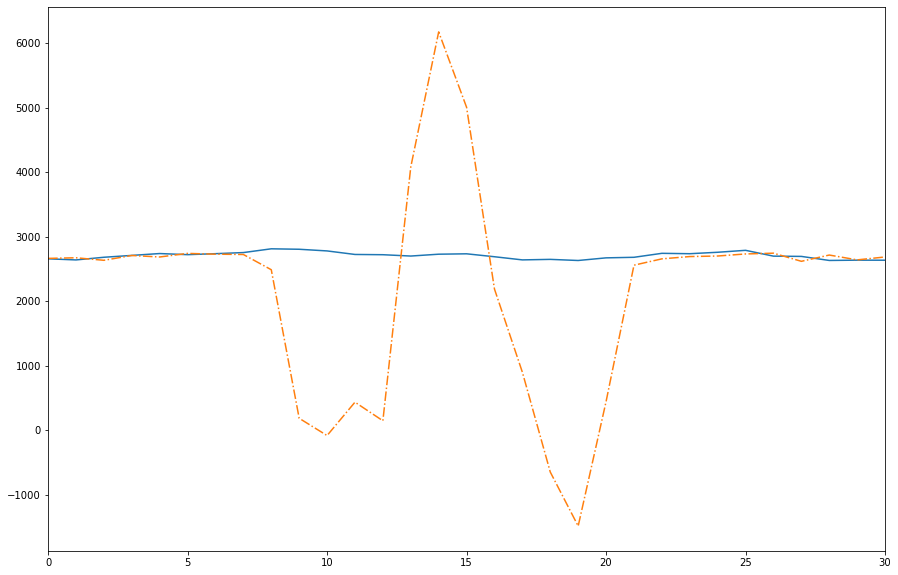

In [107]:
plt.figure(figsize = (15,10))
plt.xlim([0,30])
plt.plot(range(len(y_val_rf)), y_val_rf, '-')
plt.plot(range(len(y_linreg_pred)), y_linreg_pred, '-.')
plt.show()

***Plotting the prediction over the three sets of data***

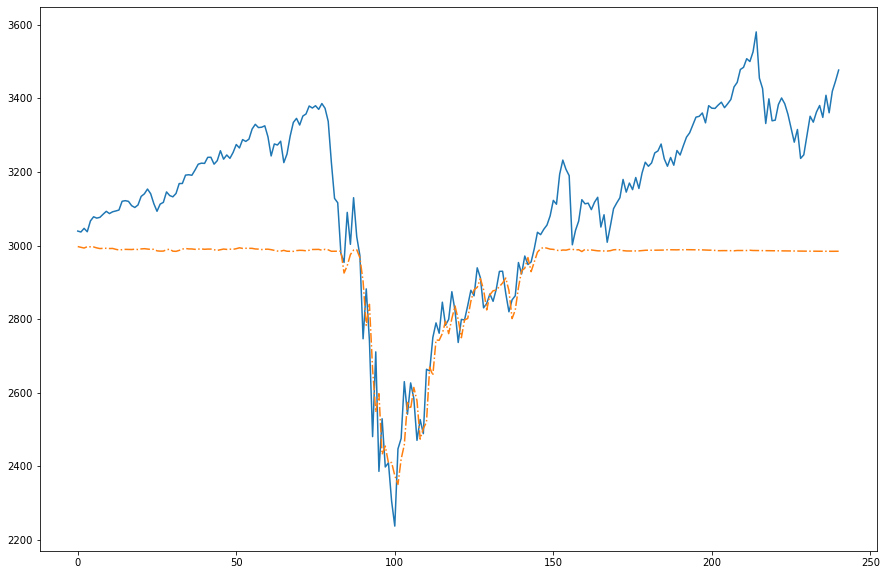

In [78]:
import matplotlib.pyplot as plt

# get our random forest's prediction over the training period
training_predictions = model_RF.predict(X_train_rf)

# plt.plot(range(len(y_train_rf)), y_train_rf, '-')
# plt.plot(range(len(training_predictions)), training_predictions, '.')
# plt.show()

validation_predictions = model_RF.predict(X_val_rf)

# plt.plot(range(len(y_val_rf)), y_val_rf, '-')
# plt.plot(range(len(validation_predictions)), validation_predictions, '.')
# plt.show()

testing_predictions = model_RF.predict(X_test_rf)
plt.figure(figsize = (15,10))
plt.plot(range(len(y_test_rf)), y_test_rf, '-')
plt.plot(range(len(testing_predictions)), testing_predictions, '-.')
plt.show()

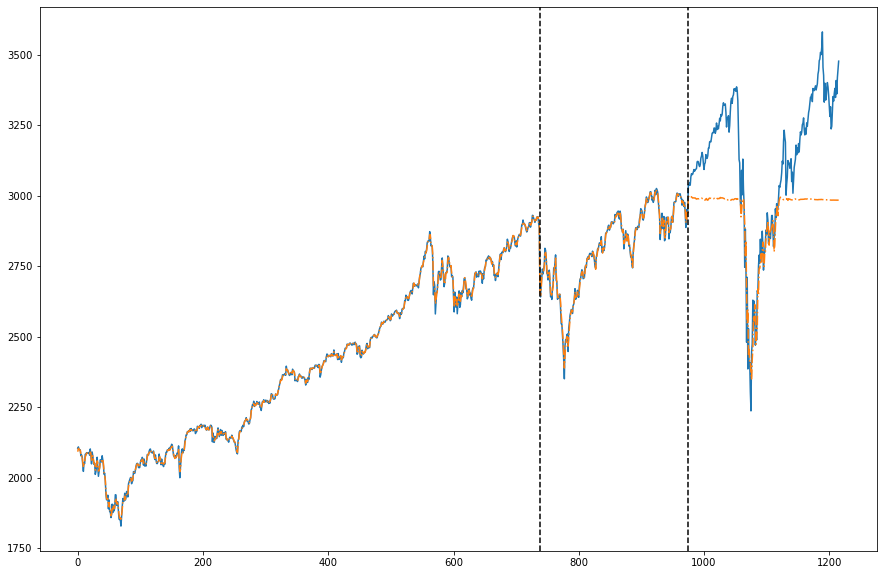

In [79]:
predictions = np.concatenate([training_predictions, 
                         validation_predictions,
                         testing_predictions])

true_series = np.concatenate([y_train_rf,
                                y_val_rf,
                                y_test_rf])

plt.figure(figsize = (15,10))
plt.plot(range(len(true_series)), true_series, '-')
plt.plot(range(len(predictions)), predictions, '-.')
# vertical lines separating the training data from the valiation
# from the testing data
plt.axvline(x=len(y_train_rf), color='k', linestyle='--')
plt.axvline(x=len(y_train_rf)+len(y_val_rf), color='k', linestyle='--')
plt.show()

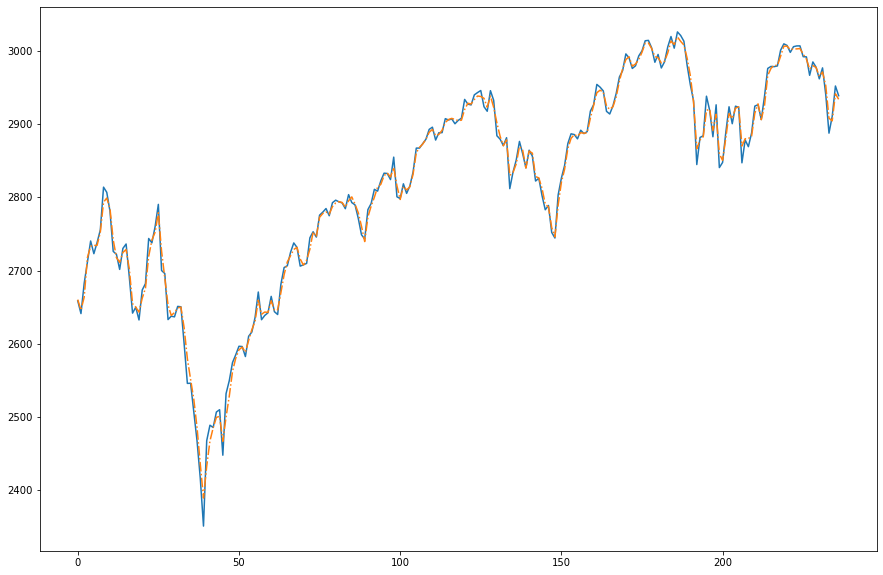

In [81]:
val_pred = model_RF.predict(X_val_rf)
plt.figure(figsize = (15,10))
plt.plot(range(len(y_val_rf)), y_val_rf, '-')
plt.plot(range(len(val_pred)), val_pred, '-.')
plt.show()

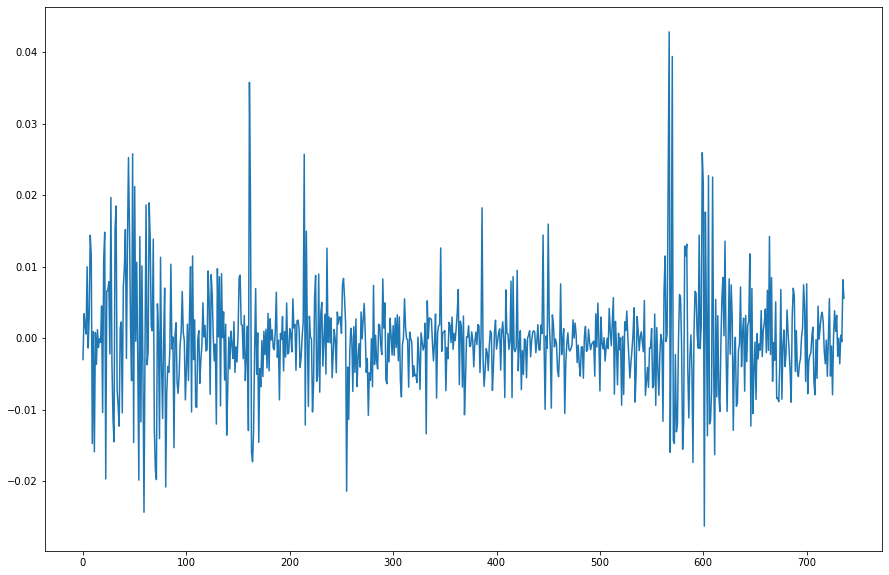

In [87]:
# plotting percent daily error
err = [float(i - j) for i, j in zip(training_predictions, np.array(y_train_rf[1:]))]
pct_err = [float(i / j) for i, j in zip(err, np.array(y_train_rf[1:]))] 

plt.figure(figsize=(15,10))
plt.plot(pct_err)
plt.show()

In [91]:
# RMSE for persistence model and for the tuned model

y_baseline_pred = persistence_predict(y_train_rf)
baseline_rmse = mean_squared_error(y_train_rf[1:], y_baseline_pred, squared=False)

print('Baseline persistence model RMSE on the training data = ',str(baseline_rmse))

tuned_train_rmse = mean_squared_error(y_train_rf, training_predictions, squared=False)

print('Tuned RF RMSE on the training data = ',str(tuned_train_rmse))

Baseline persistence model RMSE on the training data =  17.348538610020732
Tuned RF RMSE on the training data =  1.3035616127364125


------

# Debugging the overfitting in the random forest

## Linear Regresion first

***Building up from a one-day window and using change in target price as the target value***

In [112]:
X_train

Open      High       Low     Close    Volume  moving_avg_50  \
0   -1.261893 -1.282373 -1.244264 -1.257836 -1.043700            NaN   
1   -1.264133 -1.269703 -1.274461 -1.305309 -0.313123      -1.218345   
2   -1.303205 -1.313705 -1.312510 -1.337888  0.035411      -1.243204   
3   -1.327979 -1.263471 -1.292745 -1.235772  0.181478      -1.262864   
4   -1.231848 -1.231140 -1.210141 -1.203882 -0.035195      -1.245957   
..        ...       ...       ...       ...       ...            ...   
748  1.875767  1.879728  1.880024  1.869527 -0.367313       1.862093   
749  1.867188  1.860309  1.885052  1.865527 -0.313181       1.870502   
750  1.894373  1.889369  1.891904  1.872699 -0.030484       1.878092   
751  1.851855  1.820232  1.762988  1.790303 -0.176766       1.882102   
752  1.793935  1.785319  1.712613  1.735004 -0.417883       1.885578   

     moving_avg_100       Day  Days_to_election  Avg_month_temp  ...  Month_3  \
0               NaN  0.779614          1.000000        0.159902  ...      0.0   
1         -1.177777  0.782369          0.999082        0.159902  ...      0.0   
2         -1.203765  0.785124          0.998163        0.159902  ...      0.0   
3         -1.224317  0.787879          0.997245        0.159902  ...      0.0   
4         -1.206643  0.790634          0.996327        0.159902  ...      0.0   
..              ...       ...               ...             ...  ...      ...   
748        1.817391  0.749311          0.003673       -0.082026  ...      0.0   
749        1.824953  0.752066          0.002755       -0.082026  ...      0.0   
750        1.832419  0.754821          0.001837       -0.082026  ...      0.0   
751        1.838891  0.757576          0.000918       -0.082026  ...      0.0   
752        1.845464  0.760331          0.000000       -0.082026  ...      0.0   

     Month_4  Month_5  Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  \
0        0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
1        0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
2        0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
3        0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
4        0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
..       ...      ...      ...      ...      ...      ...       ...       ...   
748      0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
749      0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
750      0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
751      0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
752      0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   

     Month_12  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
..        ...  
748       0.0  
749       0.0  
750       0.0  
751       0.0  
752       0.0  

[753 rows x 25 columns]

In [160]:
# generating the datasets
X_train_1d = get_timeseries_df(X_train, y_train, 1)
X_val_1d = get_timeseries_df(X_val, y_val, 1)
X_test_1d = get_timeseries_df(X_test, y_test, 1)

# From the check above, will get rid of all non-date features expect for Open_0
cols_to_remv = ['High_0', 'Low_0', 'Close_0', 'Volume_0', 'moving_avg_50_0',
               'moving_avg_100_0', 'Avg_month_temp_0', 'Avg_month_temp_dev_0',
               'CCI_0', 'VIXCLS_0']
X_train_1d.drop(columns=cols_to_remv, inplace=True)
X_val_1d.drop(columns=cols_to_remv, inplace=True)
X_test_1d.drop(columns=cols_to_remv, inplace=True)

In [161]:
# drop rows with missing values
X_train_1d = X_train_1d.dropna()
X_val_1d = X_val_1d.dropna()
X_test_1d = X_test_1d.dropna()

In [278]:
X_train_1d

Open_0     Day_0  Days_to_election_0  Month_1_0  Month_2_0  Month_3_0  \
2   -1.303205  0.785124            0.998163        0.0        0.0        0.0   
3   -1.327979  0.787879            0.997245        0.0        0.0        0.0   
4   -1.231848  0.790634            0.996327        0.0        0.0        0.0   
5   -1.206489  0.798898            0.993572        0.0        0.0        0.0   
6   -1.201665  0.801653            0.992654        0.0        0.0        0.0   
..        ...       ...                 ...        ...        ...        ...   
748  1.875767  0.749311            0.003673        0.0        0.0        0.0   
749  1.867188  0.752066            0.002755        0.0        0.0        0.0   
750  1.894373  0.754821            0.001837        0.0        0.0        0.0   
751  1.851855  0.757576            0.000918        0.0        0.0        0.0   
752  1.793935  0.760331            0.000000        0.0        0.0        0.0   

     Month_4_0  Month_5_0  Month_6_0  Month_7_0  ...  Month_4_1  Month_5_1  \
2          0.0        0.0        0.0        0.0  ...        0.0        0.0   
3          0.0        0.0        0.0        0.0  ...        0.0        0.0   
4          0.0        0.0        0.0        0.0  ...        0.0        0.0   
5          0.0        0.0        0.0        0.0  ...        0.0        0.0   
6          0.0        0.0        0.0        0.0  ...        0.0        0.0   
..         ...        ...        ...        ...  ...        ...        ...   
748        0.0        0.0        0.0        0.0  ...        0.0        0.0   
749        0.0        0.0        0.0        0.0  ...        0.0        0.0   
750        0.0        0.0        0.0        0.0  ...        0.0        0.0   
751        0.0        0.0        0.0        0.0  ...        0.0        0.0   
752        0.0        0.0        0.0        0.0  ...        0.0        0.0   

     Month_6_1  Month_7_1  Month_8_1  Month_9_1  Month_10_1  Month_11_1  \
2          0.0        0.0        0.0        0.0         1.0         0.0   
3          0.0        0.0        0.0        0.0         1.0         0.0   
4          0.0        0.0        0.0        0.0         1.0         0.0   
5          0.0        0.0        0.0        0.0         1.0         0.0   
6          0.0        0.0        0.0        0.0         1.0         0.0   
..         ...        ...        ...        ...         ...         ...   
748        0.0        0.0        0.0        1.0         0.0         0.0   
749        0.0        0.0        0.0        0.0         1.0         0.0   
750        0.0        0.0        0.0        0.0         1.0         0.0   
751        0.0        0.0        0.0        0.0         1.0         0.0   
752        0.0        0.0        0.0        0.0         1.0         0.0   

     Month_12_1          y_1  
2           0.0  2003.689941  
3           0.0  1994.239990  
4           0.0  2023.859985  
5           0.0  2033.109985  
6           0.0  2033.660034  
..          ...          ...  
748         0.0  2913.979980  
749         0.0  2924.590088  
750         0.0  2923.429932  
751         0.0  2925.510010  
752         0.0  2901.610107  

[751 rows x 41 columns]

***And we'll change the target variable to change from day t to t+1***

In [163]:
z_train = np.subtract(y_train[1:], y_train[:-1])
z_val = np.subtract(y_val[1:], y_val[:-1])
z_test = np.subtract(y_test[1:], y_test[:-1])

In [222]:
y_train

Adj Close
0    2017.459961
1    2003.689941
2    1994.239990
3    2023.859985
4    2033.109985
..           ...
748  2924.590088
749  2923.429932
750  2925.510010
751  2901.610107
752  2885.570068

[753 rows x 1 columns]

In [167]:
z_train

Adj Close
1   -13.770020
2    -9.449951
3    29.619995
4     9.250000
5     0.550049
..         ...
748  10.610108
749  -1.160156
750   2.080078
751 -23.899903
752 -16.040039

[752 rows x 1 columns]

In [279]:
# only the training matrix has missing values in the
# first two rows (rather than just the first), so
# z_train is the only one where we have to take off an
# extra value
z_train_1d = z_train.loc[X_train_1d.index]
z_val_1d = z_val
z_test_1d = z_test

In [173]:
print(X_test_1d.shape)
print(z_test_1d.shape)

(254, 41)
(254, 1)


In [322]:
lr = LinearRegression(fit_intercept=False).fit(X_train_1d, z_train_1d)
print(lr.score(X_train_1d, z_train_1d))
# coefs = reg.coef_[0]
# for i in range(len(coefs)):
#     if np.abs(coefs[i]) val
#         print(X_train_rf.columns[i])

z_linreg_pred = lr.predict(X_test_1d)
linreg_rmse = mean_squared_error(z_test_1d, z_linreg_pred, squared=False)

print('Baseline linreg model RMSE on the test data = ',str(linreg_rmse))

0.2640886309652668
Baseline linreg model RMSE on the test data =  50.45022836509413


In [323]:
np.sqrt((z_test_1d**2).sum()/len(z_test_1d))

Adj Close    59.007166
dtype: float64

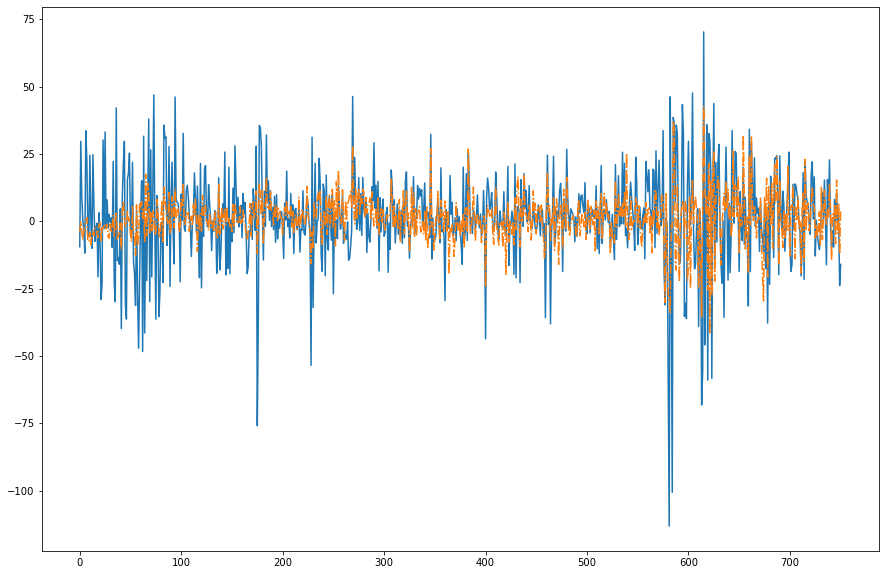

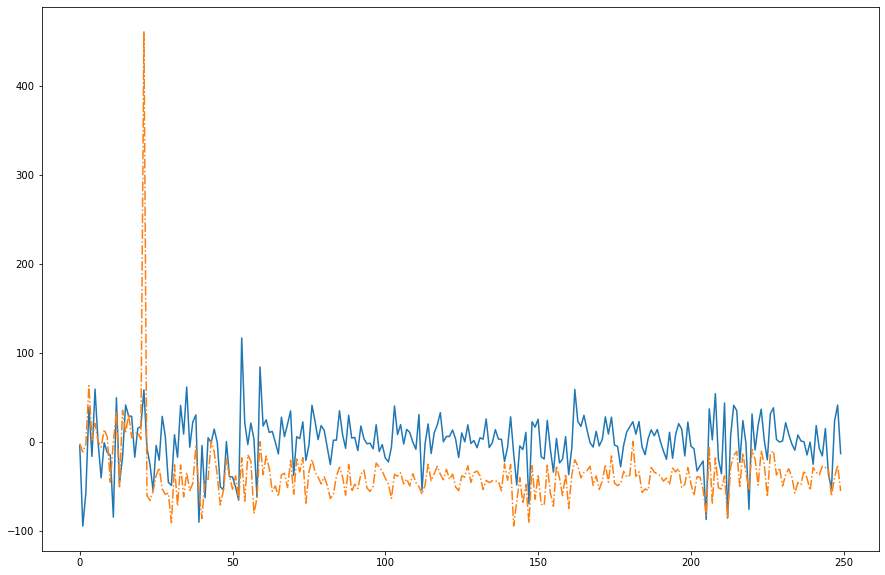

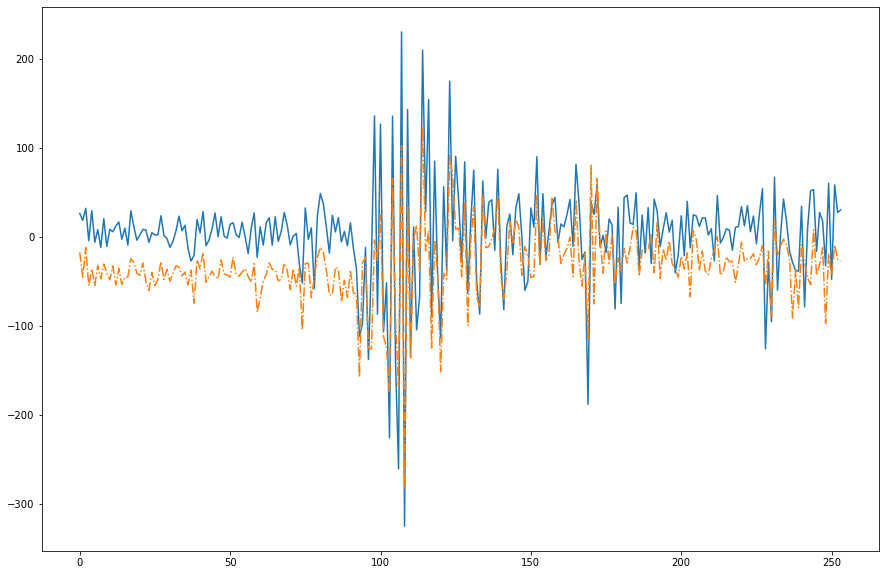

In [324]:
plt.figure(figsize = (15,10))
plt.plot(range(len(z_train_1d)), z_train_1d, '-')
plt.plot(range(len(lr.predict(X_train_1d))), lr.predict(X_train_1d), '-.')
plt.show()

plt.figure(figsize = (15,10))
plt.plot(range(len(z_val_1d)), z_val_1d, '-')
plt.plot(range(len(lr.predict(X_val_1d))), lr.predict(X_val_1d), '-.')
plt.show()

plt.figure(figsize = (15,10))
plt.plot(range(len(z_test_1d)), z_test_1d, '-')
plt.plot(range(len(lr.predict(X_test_1d))), lr.predict(X_test_1d), '-.')
plt.show()

In [326]:
lr.intercept_

0.0

In [328]:
ftrs_day21 = X_val_1d.iloc[(np.argmax(lr.predict(X_val_1d))),:].values.ravel()
reg_coefs = lr.coef_

print(np.dot(ftrs_day21, reg_coefs.ravel()))
# print(reg_coefs)
for i in range(len(X_val_1d.columns)):
    print(X_val_1d.columns[i],', ',reg_coefs[0][i])

460.51808625286066
Open_0 ,  386.0186099269909
Day_0 ,  -31.963235793716176
Days_to_election_0 ,  324.46367381778066
Month_1_0 ,  -15.092338403141051
Month_2_0 ,  -12.316449495133993
Month_3_0 ,  -6.496326356861053
Month_4_0 ,  -15.435240603464297
Month_5_0 ,  -4.330504139184911
Month_6_0 ,  4.791572680581067
Month_7_0 ,  16.250903591786866
Month_8_0 ,  11.455614219614151
Month_9_0 ,  12.032906951287766
Month_10_0 ,  14.60146965494665
Month_11_0 ,  16.798082964537112
Month_12_0 ,  19.756074966696936
Open_1 ,  64.61519332517705
High_1 ,  -28.61357831297929
Low_1 ,  -76.26781127082845
Close_1 ,  -345.07969099105804
Volume_1 ,  -0.6533761760024913
moving_avg_50_1 ,  -9.87609545029917
moving_avg_100_1 ,  -4.099129720444236
Day_1 ,  16.52272339275258
Days_to_election_1 ,  -362.63152480391904
Avg_month_temp_1 ,  -2.7869042226269904
Avg_month_temp_dev_1 ,  1.6548959630876474
CCI_1 ,  0.5264816002359792
VIXCLS_1 ,  1.9533993202825444
Month_1_1 ,  11.753561442961594
Month_2_1 ,  6.3792823373264

### Trying a 5-day window

In [183]:
# generating the datasets
X_train_5d = get_timeseries_df(X_train, y_train, 5)
X_val_5d = get_timeseries_df(X_val, y_val, 5)
X_test_5d = get_timeseries_df(X_test, y_test, 5)

# From the check above, will get rid of all non-date features expect for Open_0
cols_to_remv = ['High_0', 'Low_0', 'Close_0', 'Volume_0', 'moving_avg_50_0',
               'moving_avg_100_0', 'Avg_month_temp_0', 'Avg_month_temp_dev_0',
               'CCI_0', 'VIXCLS_0']
X_train_5d.drop(columns=cols_to_remv, inplace=True)
X_val_5d.drop(columns=cols_to_remv, inplace=True)
X_test_5d.drop(columns=cols_to_remv, inplace=True)

In [186]:
# drop rows with missing values
X_train_5d = X_train_5d.dropna()
X_val_5d = X_val_5d.dropna()
X_test_5d = X_test_5d.dropna()

In [193]:
z_train_5d = z_train.loc[X_train_5d.index]
z_val_5d = z_val.loc[X_val_5d.index]
z_test_5d = z_test.loc[X_test_5d.index]

In [218]:
lr_5d = LinearRegression().fit(X_train_5d, z_train_5d)
print(lr_5d.score(X_train_5d, z_train_5d))

linreg_rmse_5d = mean_squared_error(z_train_5d, lr_5d.predict(X_train_5d), squared=False)

print('Baseline linreg model RMSE on the train data = ',str(linreg_rmse_5d))

0.3987545881418022
Baseline linreg model RMSE on the train data =  13.426908224524576


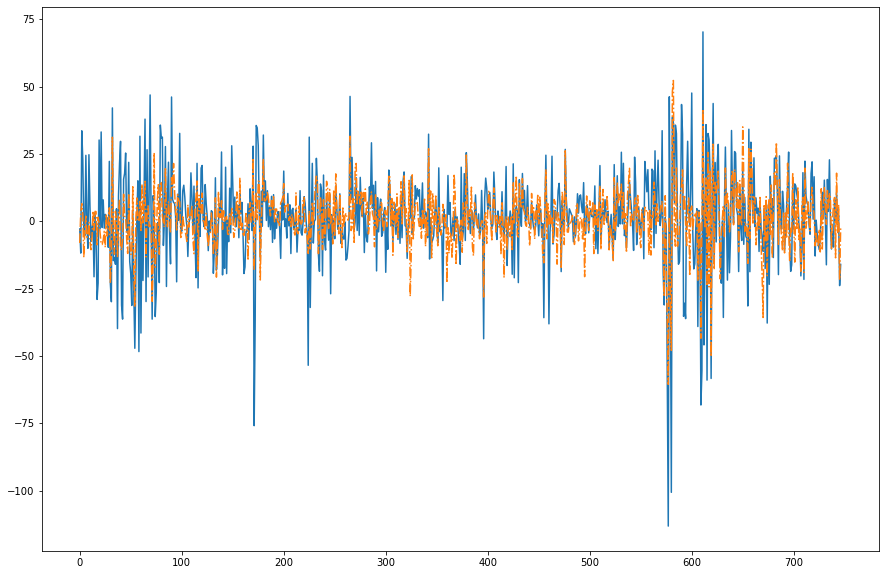

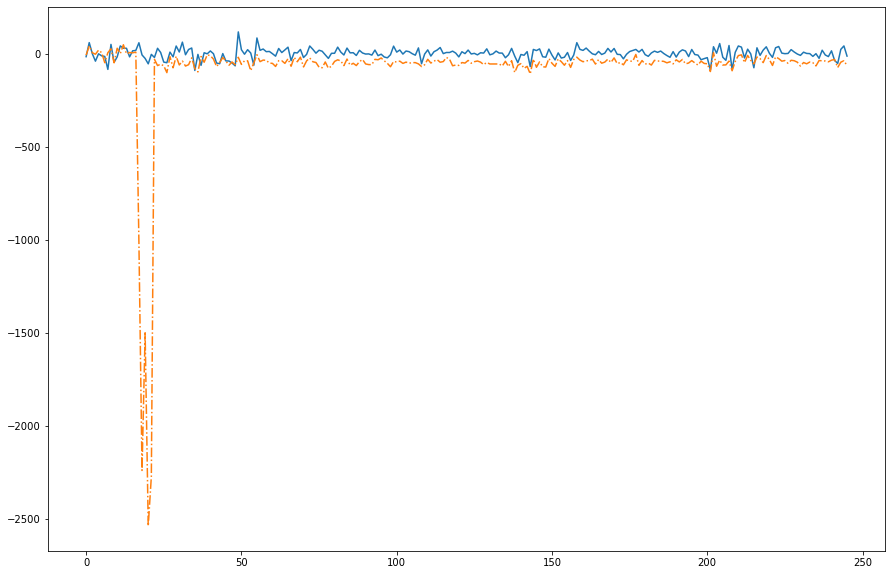

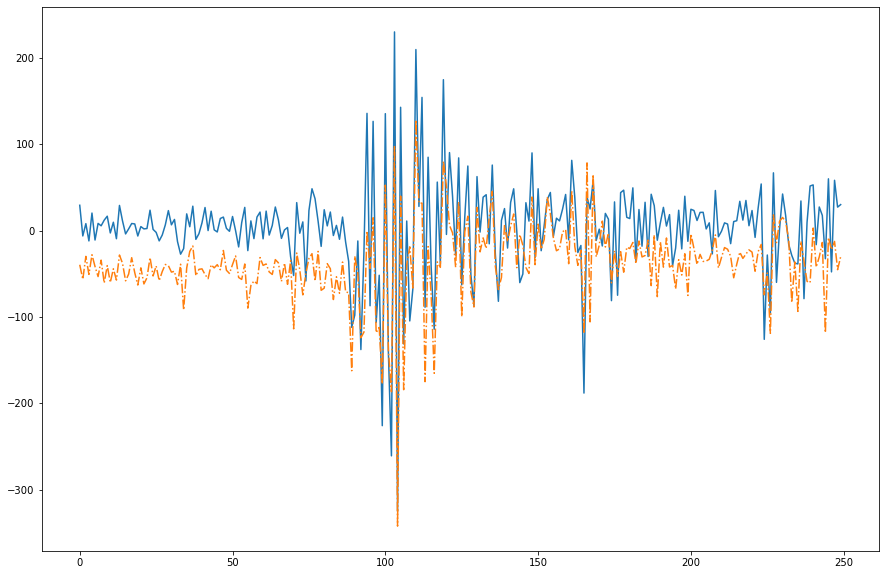

In [201]:
plt.figure(figsize = (15,10))
plt.plot(range(len(z_train_5d)), z_train_5d, '-')
plt.plot(range(len(lr_5d.predict(X_train_5d))), lr_5d.predict(X_train_5d), '-.')
plt.show()

plt.figure(figsize = (15,10))
plt.plot(range(len(z_val_5d)), z_val_5d, '-')
plt.plot(range(len(lr_5d.predict(X_val_5d))), lr_5d.predict(X_val_5d), '-.')
plt.show()

plt.figure(figsize = (15,10))
plt.plot(range(len(z_test_5d)), z_test_5d, '-')
plt.plot(range(len(lr_5d.predict(X_test_5d))), lr_5d.predict(X_test_5d), '-.')
plt.show()

### 10-day window

In [206]:
# generating the datasets
X_train_10d = get_timeseries_df(X_train, y_train, 10)
X_val_10d = get_timeseries_df(X_val, y_val, 10)
X_test_10d = get_timeseries_df(X_test, y_test, 10)

# From the check above, will get rid of all non-date features expect for Open_0
cols_to_remv = ['High_0', 'Low_0', 'Close_0', 'Volume_0', 'moving_avg_50_0',
               'moving_avg_100_0', 'Avg_month_temp_0', 'Avg_month_temp_dev_0',
               'CCI_0', 'VIXCLS_0']
X_train_10d.drop(columns=cols_to_remv, inplace=True)
X_val_10d.drop(columns=cols_to_remv, inplace=True)
X_test_10d.drop(columns=cols_to_remv, inplace=True)

In [207]:
# drop rows with missing values
X_train_10d = X_train_10d.dropna()
X_val_10d = X_val_10d.dropna()
X_test_10d = X_test_10d.dropna()

In [208]:
z_train_10d = z_train.loc[X_train_10d.index]
z_val_10d = z_val.loc[X_val_10d.index]
z_test_10d = z_test.loc[X_test_10d.index]

In [217]:
lr_10d = LinearRegression().fit(X_train_10d, z_train_10d)
print(lr_10d.score(X_train_10d, z_train_10d))

linreg_rmse_10d = mean_squared_error(z_train_10d, lr_10d.predict(X_train_10d), squared=False)

print('Baseline linreg model RMSE on the train data = ',str(linreg_rmse_10d))

0.5159682007244712
Baseline linreg model RMSE on the train data =  12.04108927489781


### 14-day window

In [210]:
# generating the datasets
X_train_14d = get_timeseries_df(X_train, y_train, 14)
X_val_14d = get_timeseries_df(X_val, y_val, 14)
X_test_14d = get_timeseries_df(X_test, y_test, 14)

# From the check above, will get rid of all non-date features expect for Open_0
cols_to_remv = ['High_0', 'Low_0', 'Close_0', 'Volume_0', 'moving_avg_50_0',
               'moving_avg_100_0', 'Avg_month_temp_0', 'Avg_month_temp_dev_0',
               'CCI_0', 'VIXCLS_0']
X_train_14d.drop(columns=cols_to_remv, inplace=True)
X_val_14d.drop(columns=cols_to_remv, inplace=True)
X_test_14d.drop(columns=cols_to_remv, inplace=True)

In [211]:
# drop rows with missing values
X_train_14d = X_train_14d.dropna()
X_val_14d = X_val_14d.dropna()
X_test_14d = X_test_14d.dropna()

In [212]:
z_train_14d = z_train.loc[X_train_14d.index]
z_val_14d = z_val.loc[X_val_14d.index]
z_test_14d = z_test.loc[X_test_14d.index]

In [237]:
lr_14d = LinearRegression().fit(X_train_14d, z_train_14d)
print(lr_14d.score(X_test_14d, z_test_14d))

linreg_rmse_14d = mean_squared_error(z_train_14d, lr_14d.predict(X_train_14d), squared=False)

print('Baseline linreg model RMSE on the train data = ',str(linreg_rmse_14d))

0.16981556401097875
Baseline linreg model RMSE on the train data =  10.816931860760738


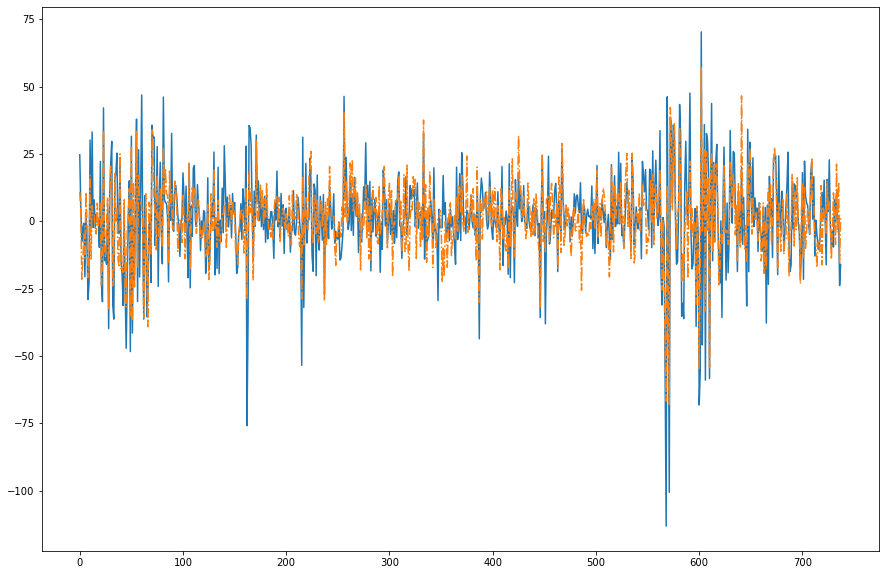

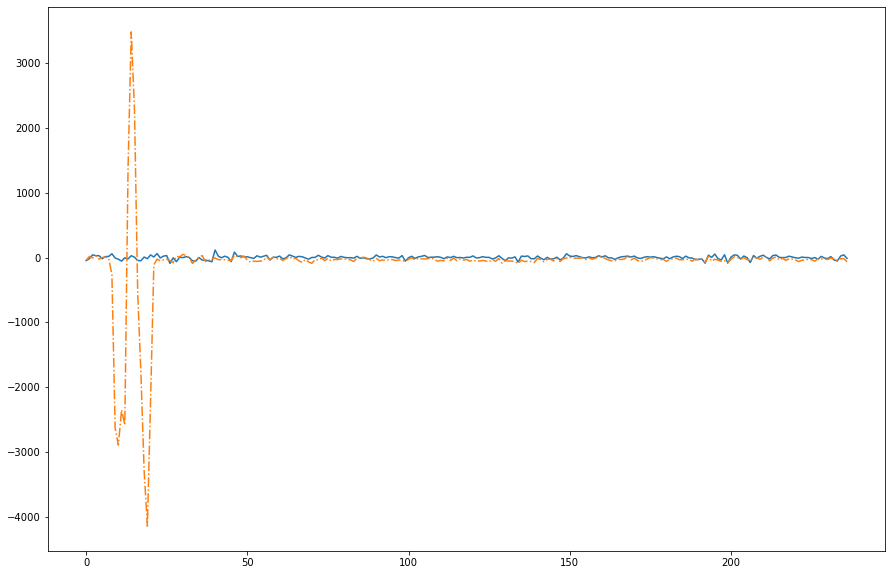

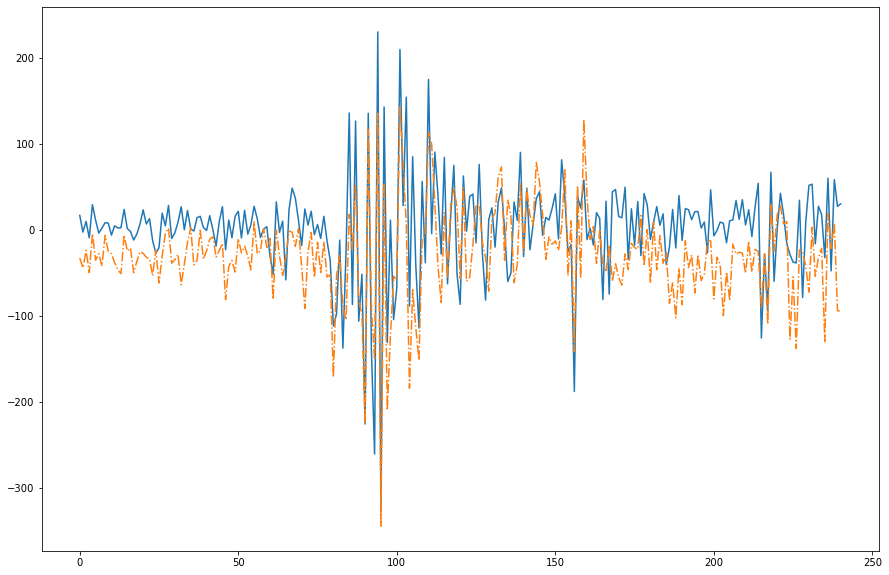

In [215]:
plt.figure(figsize = (15,10))
plt.plot(range(len(z_train_14d)), z_train_14d, '-')
plt.plot(range(len(lr_14d.predict(X_train_14d))), lr_14d.predict(X_train_14d), '-.')
plt.show()

plt.figure(figsize = (15,10))
plt.plot(range(len(z_val_14d)), z_val_14d, '-')
plt.plot(range(len(lr_14d.predict(X_val_14d))), lr_14d.predict(X_val_14d), '-.')
plt.show()

plt.figure(figsize = (15,10))
plt.plot(range(len(z_test_14d)), z_test_14d, '-')
plt.plot(range(len(lr_14d.predict(X_test_14d))), lr_14d.predict(X_test_14d), '-.')
plt.show()

***and let's see what this looks like as a prediction of the actual value***

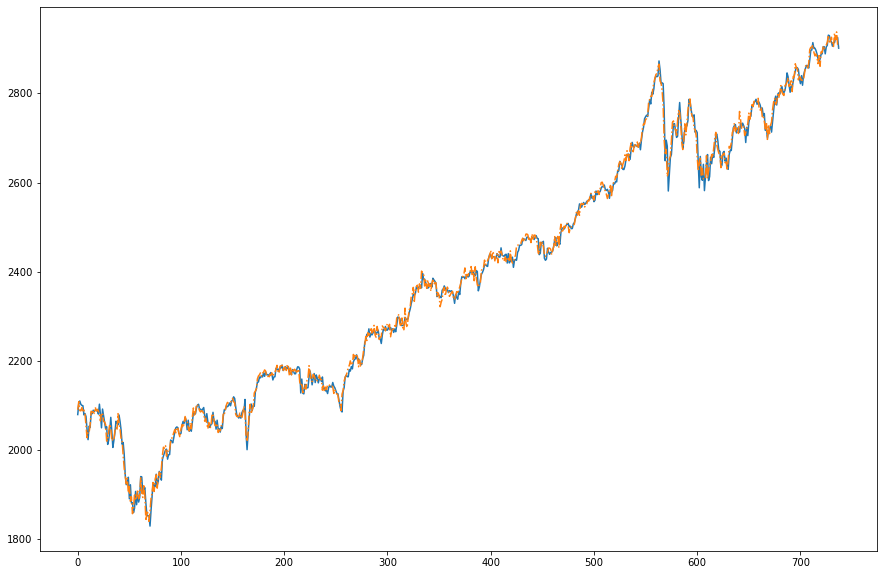

In [231]:
# we have a prediction for the days 15,...,752
# given by the indexes X_train_14d.index

# target variable z is set up such that
# y_train[i] + z_train[i+1] = y_train[i+1]

# so to turn this into the y predictions given our delta predictions:
lr_14_y_train_pred = np.add(y_train.loc[range(14,752)], lr_14d.predict(X_train_14d))
plt.figure(figsize = (15,10))
plt.plot(range(len(y_train.loc[range(14,752)])), y_train.loc[range(14,752)], '-')
plt.plot(range(len(lr_14_y_train_pred)), lr_14_y_train_pred, '-.')
plt.show()

In [232]:
print(X_val_14d.index)
print(X_test_14d.index)

Int64Index([ 14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
            ...
            241, 242, 243, 244, 245, 246, 247, 248, 249, 250],
           dtype='int64', length=237)
Int64Index([ 14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
            ...
            245, 246, 247, 248, 249, 250, 251, 252, 253, 254],
           dtype='int64', length=241)


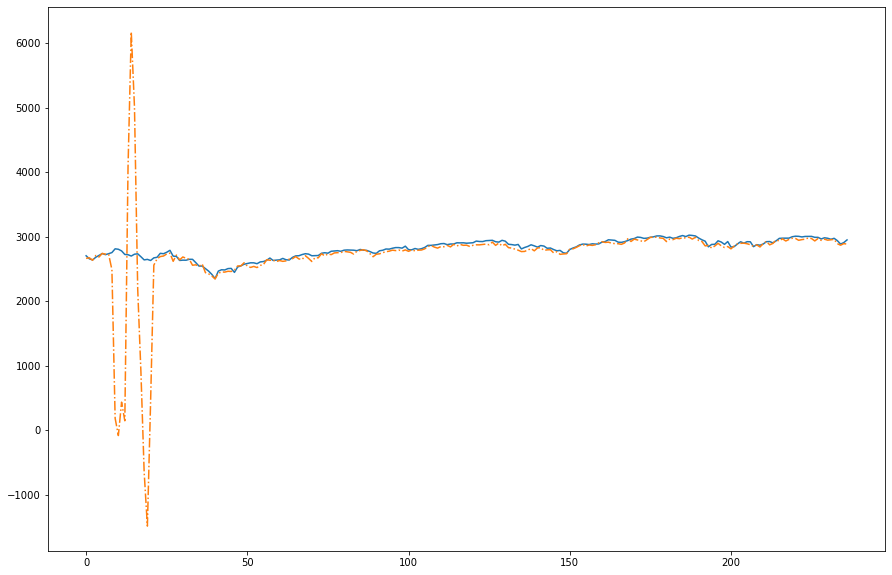

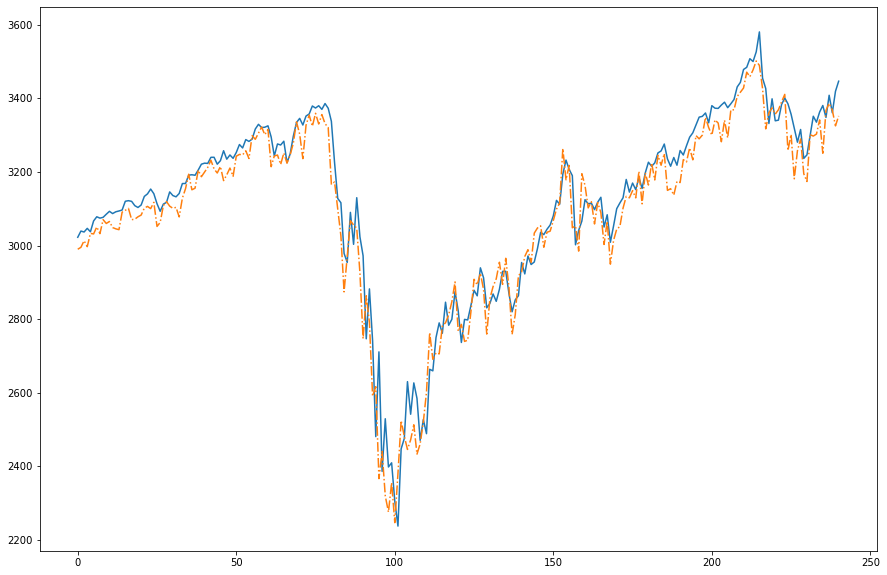

In [233]:
lr_14_y_val_pred = np.add(y_val.loc[range(13,250)], lr_14d.predict(X_val_14d))
plt.figure(figsize = (15,10))
plt.plot(range(len(y_val.loc[range(13,250)])), y_val.loc[range(13,250)], '-')
plt.plot(range(len(lr_14_y_val_pred)), lr_14_y_val_pred, '-.')
plt.show()

lr_14_y_test_pred = np.add(y_test.loc[range(13,254)], lr_14d.predict(X_test_14d))
plt.figure(figsize = (15,10))
plt.plot(range(len(y_test.loc[range(13,254)])), y_test.loc[range(13,254)], '-')
plt.plot(range(len(lr_14_y_test_pred)), lr_14_y_test_pred, '-.')
plt.show()

### Trying Random Forest with the z target variable

In [334]:
rf_z = RandomForestRegressor(random_state=42, max_depth=30, max_features=0.9, criterion='mae')
rf_z.fit(X_train_14d, z_train_14d.values.ravel())

RandomForestRegressor(criterion='mae', max_depth=30, max_features=0.9,
                      random_state=42)

In [339]:
rf_z.score(X_test_14d, z_test_14d)

-0.008539991422086946

In [336]:
rf_rmse_14d = mean_squared_error(z_test_14d, rf_z.predict(X_test_14d), squared=False)

print('Baseline linreg model RMSE on the train data = ',str(rf_rmse_14d))

Baseline linreg model RMSE on the train data =  60.66851499451093


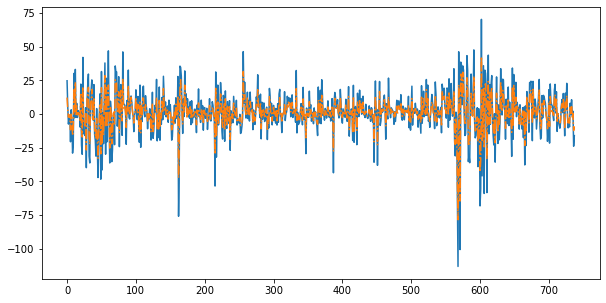

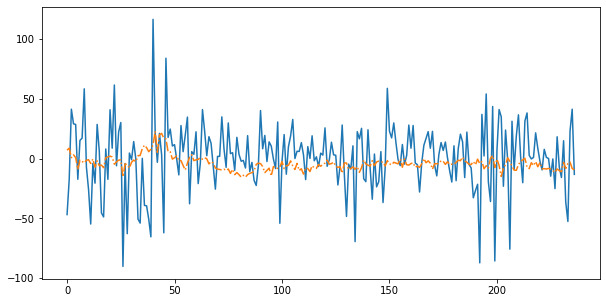

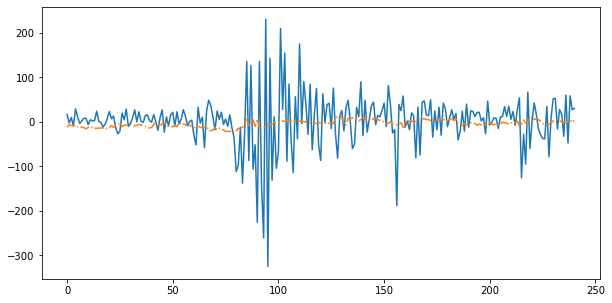

In [337]:
train_pred = rf_z.predict(X_train_14d)
plt.figure(figsize = (10,5))
plt.plot(range(len(z_train_14d)), z_train_14d, '-')
plt.plot(range(len(train_pred)), train_pred, '-.')
plt.show()

val_pred = rf_z.predict(X_val_14d)
plt.figure(figsize = (10,5))
plt.plot(range(len(z_val_14d)), z_val_14d, '-')
plt.plot(range(len(val_pred)), val_pred, '-.')
plt.show()

test_pred = rf_z.predict(X_test_14d)
plt.figure(figsize = (10,5))
plt.plot(range(len(z_test_14d)), z_test_14d, '-')
plt.plot(range(len(test_pred)), test_pred, '-.')
plt.show()

***For each prediction of the deltas (z) we will give the R2 from the random forest, the RMSE for each prediction, plots of the prediction versus true deltas, plot of the distributions of the true and predicted z, confusion matrix for the classification task of predicting the sign of the delta***

*Here we'll make each one for the validation data as a template*

*Below: method to plot an sklear confusion matrix - citation: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html*

In [453]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          # adding our optional save_fig flag with 
                          # model name and data name for saving
                          save_figs=False,
                          model_name='',
                          data_name=''):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()
    if save_figs:
        plt.savefig('../figures/'+model_name+'_delta_class_confusion_'+data_name+'.png', dpi=300)
    plt.show()

In [454]:
# we'll want to generate these same values and plots for different
# models on different data sets so we'll wrap it in a function that takes
# in a model and a data set

# model name and savefigs are optional, if we want to use this to save these figures
# then we'll turn the save_figs flag to true and include a model name for unique files organization

def model_analysis(model, z_data, x_data, data_name, model_name='', save_figs=False):
    '''Function to generate analysis values and plots from
    a given model on a given data set. Also takes name of 
    dataset (i.e. train, val, or test) for printing purposes'''
    
    # R2
    print('R2 on the',data_name,'data = ',model.score(x_data, z_data))

    # RMSE
    rmse = mean_squared_error(z_data, model.predict(x_data), squared=False)
    print('RMSE on the',data_name,'data = ',str(rmse))

    # time series plot
    pred = model.predict(x_data)
    plt.figure(figsize = (10,5))
    plt.plot(range(len(z_data)), z_data, '-')
    plt.plot(range(len(pred)), pred, '-.')
    plt.title('True versus predicted '+data_name+' deltas')
    plt.ylabel('Delta (change in adj. close from previous day)')
    plt.xlabel('Day')
    if save_figs:
        plt.savefig('../figures/'+model_name+'_time_series_delta_pred_'+data_name+'.png', dpi=300)
    plt.show()

    # scatter plot
    plt.figure(figsize = (10,5))
    plt.scatter(z_data, pred, s=10, alpha=0.7)
    plt.title('True versus predicted '+data_name+' deltas')
    plt.ylabel('Predicted delta')
    plt.xlabel('True delta')
    if save_figs:
        plt.savefig('../figures/'+model_name+'_scatter_delta_'+data_name+'.png', dpi=300)
    plt.show()

    # plot of distributions
    plt.figure(figsize = (10,5))
    plt.hist(np.array(z_data),
             alpha=0.5,
             density=True)
    plt.hist(np.array(pred),
             alpha=0.5,
             density=True)
    labels= ["true","predicted"]
    plt.legend(labels)
    plt.title('Distributions of true versus predicted '+data_name+' deltas')
    plt.ylabel('Proportion of delta values')
    plt.xlabel('Delta')
    if save_figs:
        plt.savefig('../figures/'+model_name+'_delta_dists_'+data_name+'.png', dpi=300)
    plt.show()

    # confusion matrix
    # ---> Here we'll prepare the categorical translation of the task by
    # -------> Casting positive deltas to z=1 and negative deltas to z=0
    from sklearn.metrics import confusion_matrix
    # ---> sklearn needs z_true and z_pred
    # (casting to np.arrays for consistency)
    z_class_true = np.array(np.sign(z_data))
    z_class_pred = np.array(np.sign(pred))
    
    # ---> mapping values of zero into the positive class
    # (this is a correction step for the small number of 
    # zero-valued deltas that may appear)
    z_class_true = np.where(z_class_true==0.0, 1.0, z_class_true)
    z_class_true = np.where(z_class_true==0.0, 1.0, z_class_true)
    
    cm=confusion_matrix(z_class_true, z_class_pred)
    if save_figs:
        plot_confusion_matrix(cm=cm, 
                          normalize=True,
                          target_names=['positive delta', 'negative delta'],
                          title="Classification task: sign of delta",
                          save_figs=True,
                          model_name=model_name,
                          data_name=data_name)
    else:
        plot_confusion_matrix(cm=cm, 
                          normalize=True,
                          target_names=['positive delta', 'negative delta'],
                          title="Classification task: sign of delta")

R2 on the training data =  0.8302024946236836
RMSE on the training data =  7.13951197410748


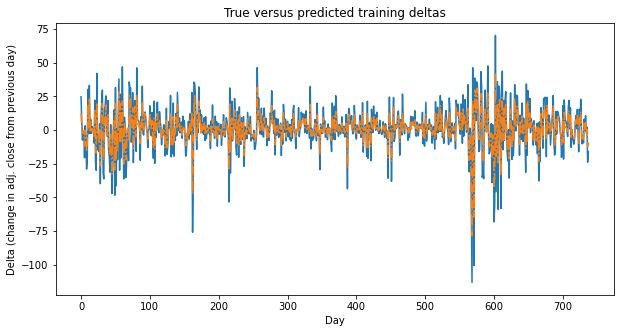

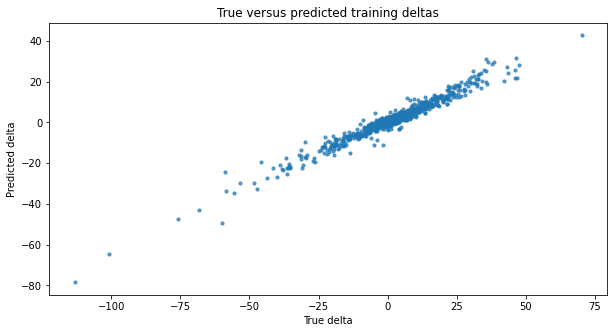

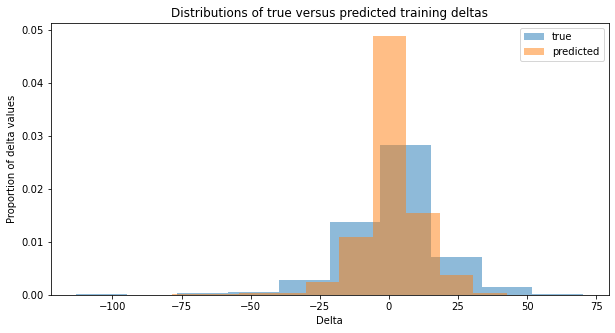

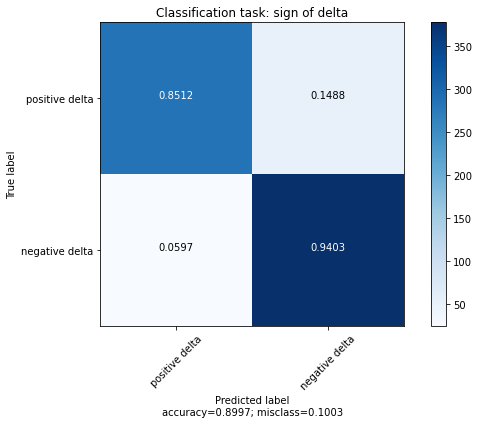

In [478]:
model_analysis(rf_z, z_train_14d, X_train_14d, 'training')

R2 on the val data =  -0.05819259099894092
RMSE on the val data =  28.466774888286412


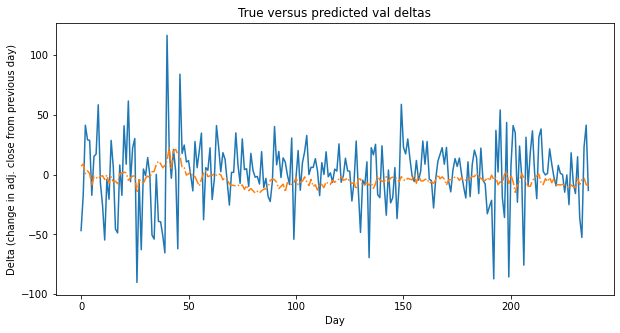

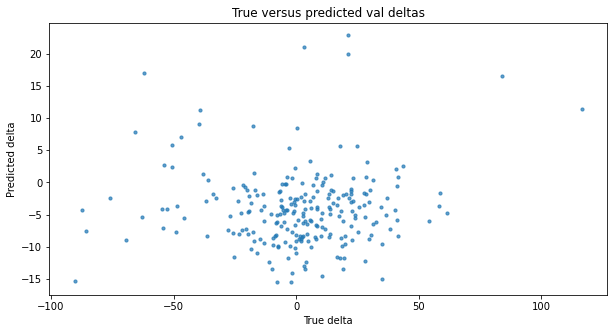

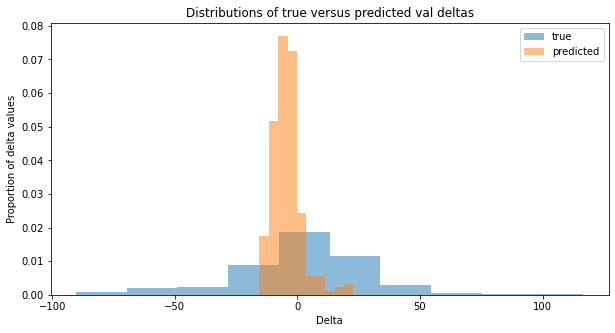

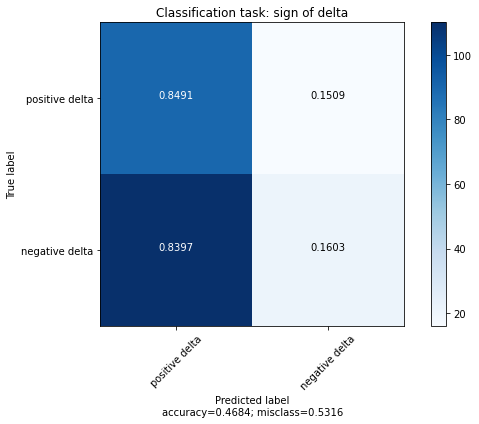

In [485]:
model_analysis(rf_z, z_val_14d, X_val_14d, 'val')

R2 on the test data =  -0.008539991422086946
RMSE on the test data =  60.66851499451093


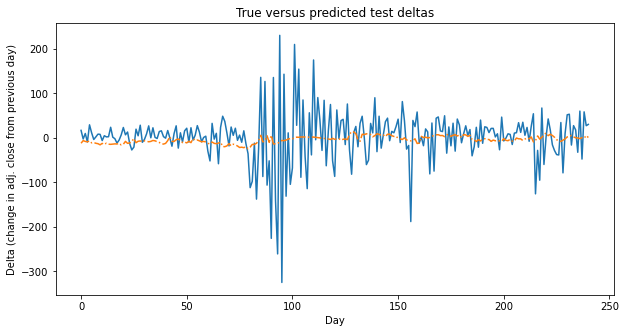

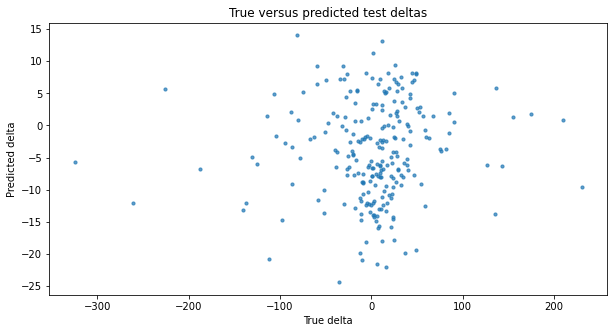

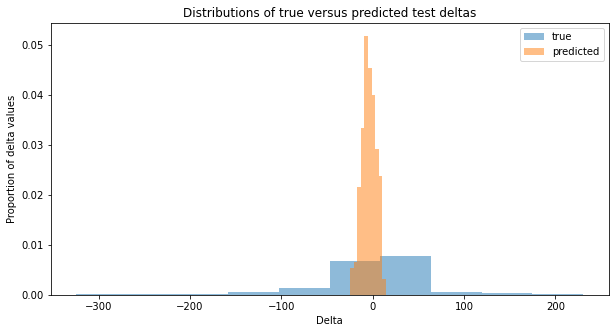

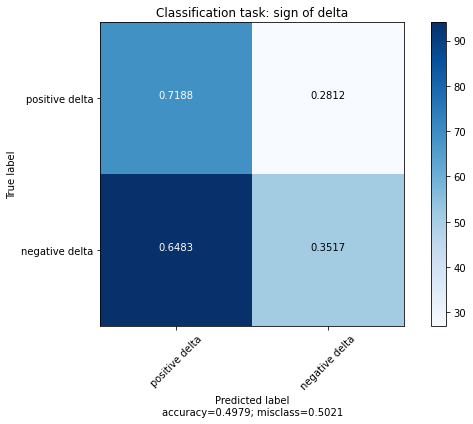

In [490]:
model_analysis(rf_z, z_test_14d, X_test_14d, 'test')

***Reconstructing the adj. close price prediction***

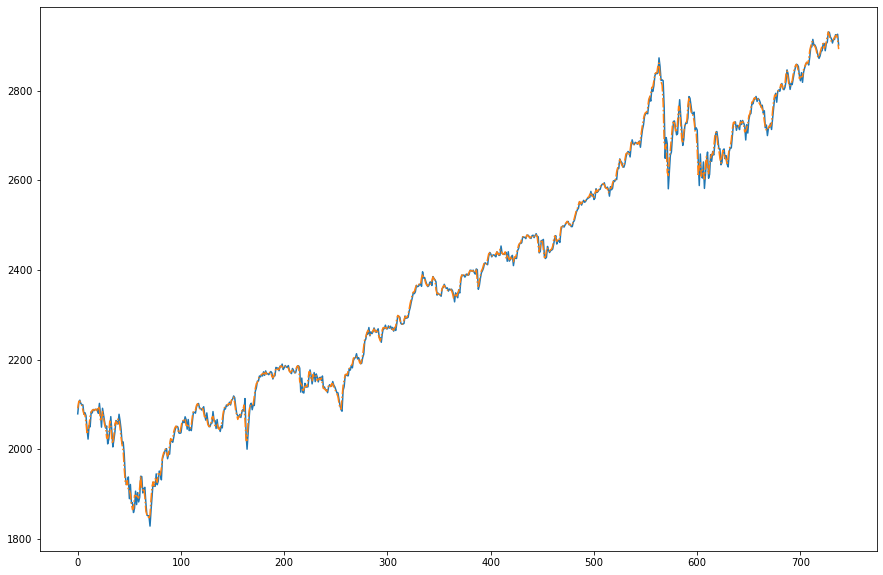

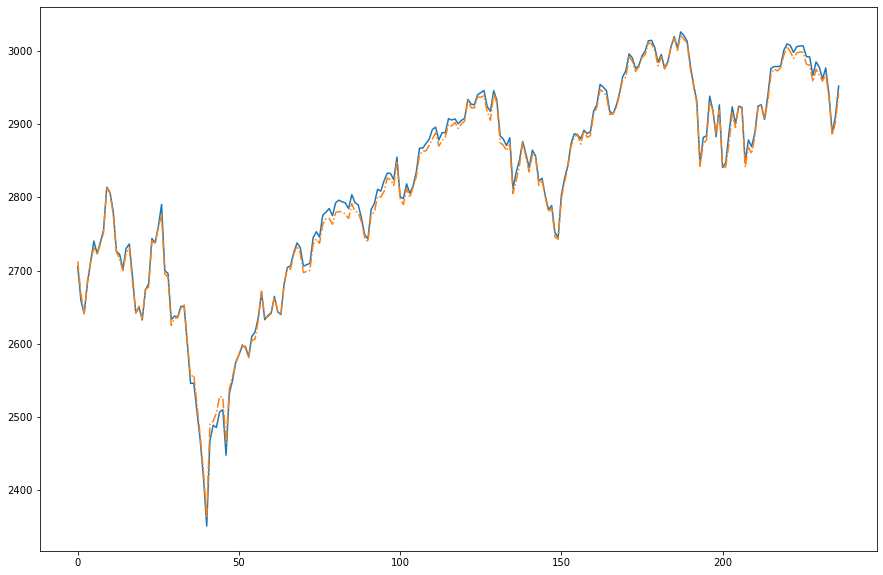

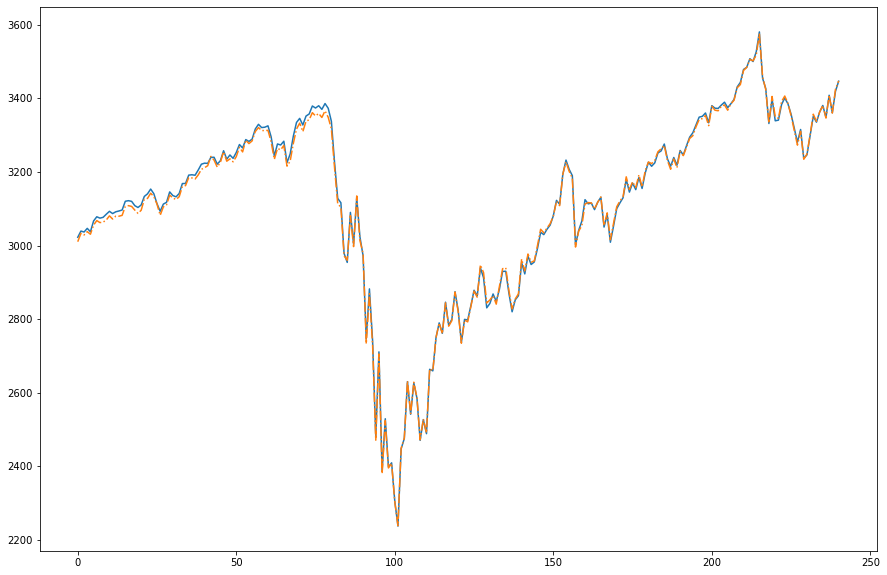

In [338]:
## we have a prediction for the days 15,...,752
## given by the indexes X_train_14d.index
# X_train_14d.index

# target variable z is set up such that
# y_train[i] + z_train[i+1] = y_train[i+1]

# so to turn this into the y predictions given our delta predictions:
rf_14_y_train_pred = np.add(y_train.loc[X_train_14d.index-1].values.ravel(), rf_z.predict(X_train_14d))
plt.figure(figsize = (15,10))
plt.plot(range(len(y_train.loc[X_train_14d.index-1])), y_train.loc[X_train_14d.index-1], '-')
plt.plot(range(len(rf_14_y_train_pred)), rf_14_y_train_pred, '-.')
plt.show()

# ... and the same for validation and testing
rf_14_y_val_pred = np.add(y_val.loc[X_val_14d.index-1].values.ravel(), rf_z.predict(X_val_14d))
plt.figure(figsize = (15,10))
plt.plot(range(len(y_val.loc[X_val_14d.index-1])), y_val.loc[X_val_14d.index-1], '-')
plt.plot(range(len(rf_14_y_val_pred)), rf_14_y_val_pred, '-.')
plt.show()

rf_14_y_test_pred = np.add(y_test.loc[X_test_14d.index-1].values.ravel(), rf_z.predict(X_test_14d))
plt.figure(figsize = (15,10))
plt.plot(range(len(y_test.loc[X_test_14d.index-1])), y_test.loc[X_test_14d.index-1], '-')
plt.plot(range(len(rf_14_y_test_pred)), rf_14_y_test_pred, '-.')
plt.show()

## Hyperparameter tuning: Random Forest
***Now predicting the target variable z of the delta in the adjusted close price***

### The model it chooses is the single-layer regressor - Hardly different from the naive persistence model

In [481]:
from sklearn.ensemble import RandomForestRegressor

# we fix the model's random state here
ML_algo_RF = RandomForestRegressor(random_state=42)
param_grid = {'max_depth': [i for i in range(1,50,5)],
               # the max_depth should be smaller or equal than the number of features roughly
               # we'll limit it to 50 because while we have >350 features in the 14-day windowed
               # dataset, ~ 25 of those come from each day, so we expect overfitting far before 350
              'max_features': [0.5,0.6,0.7,0.8,0.9,1.0], 
              # linearly spaced between 0.5 and 1
              'criterion': ['mse','mae']}
model_RF, score_RF = ML_pipe_RMSE(X_train_14d,
                            z_train_14d, 
                            X_val_14d, 
                            z_val_14d, 
                            ML_algo_RF, 
                            param_grid)
print('Val score: ',score_RF)

best model parameters: {'criterion': 'mae', 'max_depth': 1, 'max_features': 1.0}
Val score:  26.920122741221977


Baseline regression RMSE =  17.32618206185664
R2 on the training data =  0.019254316674334637
RMSE on the training data =  17.158569425553168


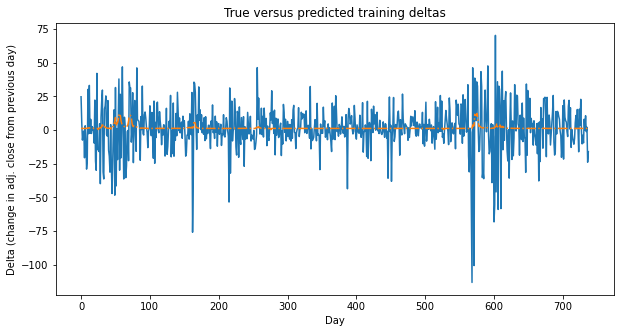

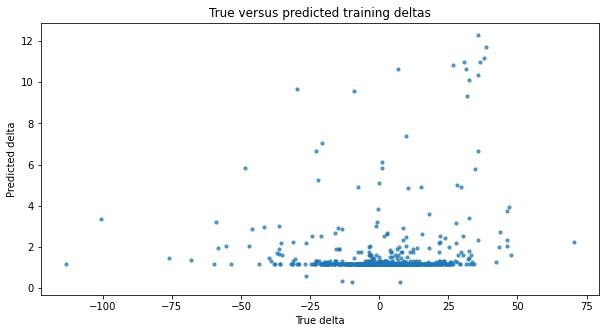

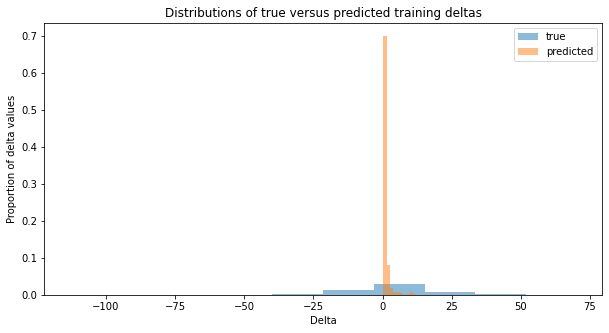

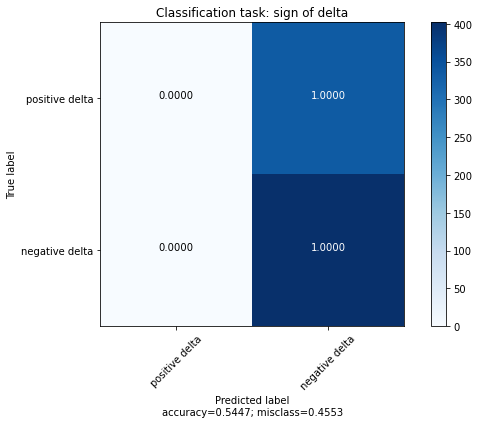

In [497]:
# we'll also show the baseline RMSE for predicting the mean z
baseline_train = mean_squared_error(z_train_14d, np.full(z_train_14d.shape, np.mean(z_train_14d)), squared=False)
print('Baseline regression RMSE = ',baseline_train)
model_analysis(model_RF, z_train_14d, X_train_14d, 'training', model_name='HP_TUNED_RF', save_figs=True)

Baseline regression RMSE =  27.672978698613917
R2 on the validation data =  0.053670771860684474
RMSE on the validation data =  26.920122741221977


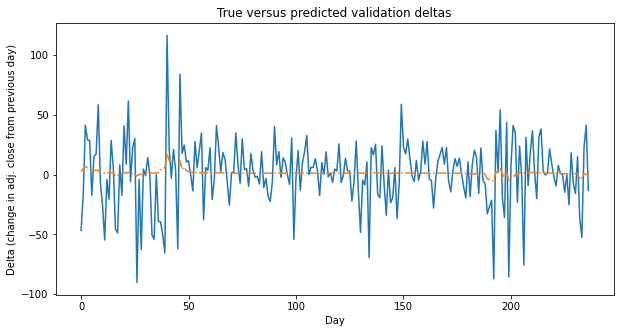

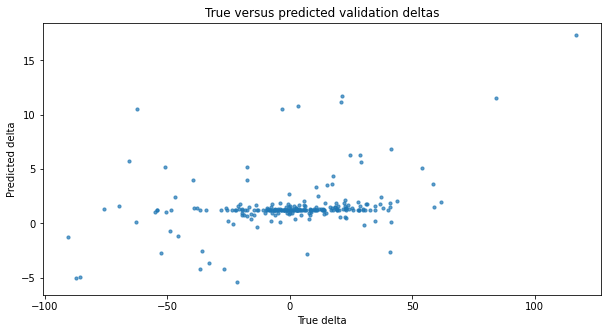

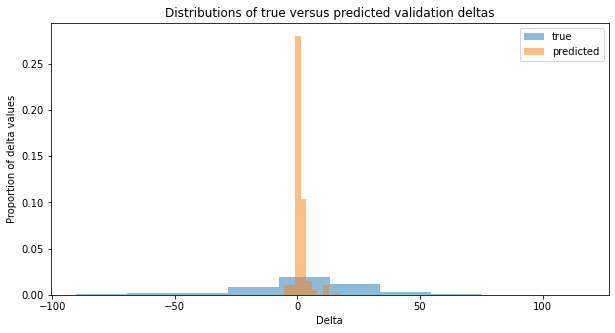

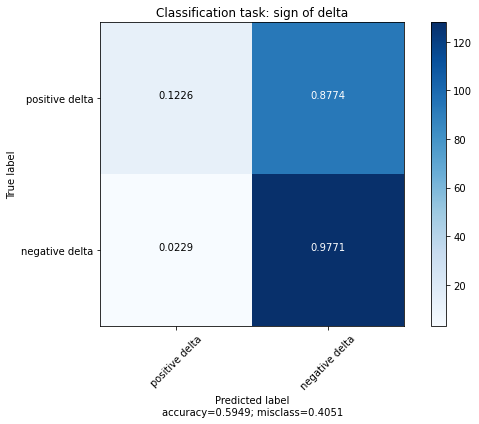

In [498]:
baseline_val = mean_squared_error(z_val_14d, np.full(z_val_14d.shape, np.mean(z_val_14d)), squared=False)
print('Baseline regression RMSE = ',baseline_val)

model_analysis(model_RF, z_val_14d, X_val_14d, 'validation', model_name='HP_TUNED_RF', save_figs=True)

Baseline regression RMSE =  60.41110821611641
R2 on the testing data =  -0.017040739225261836
RMSE on the testing data =  60.92365885034746


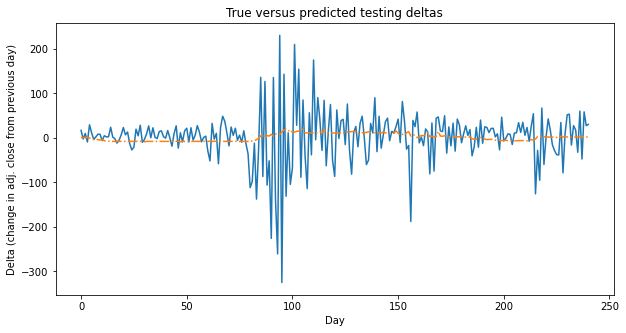

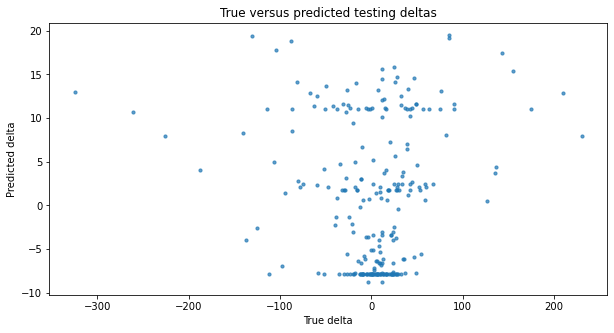

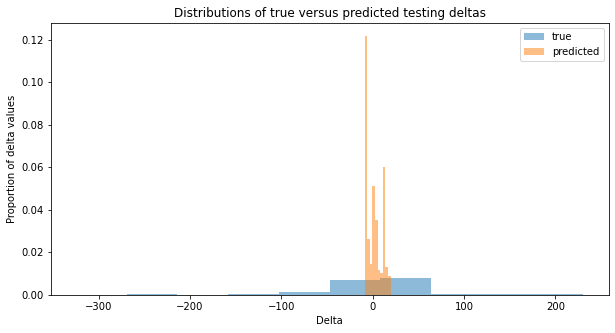

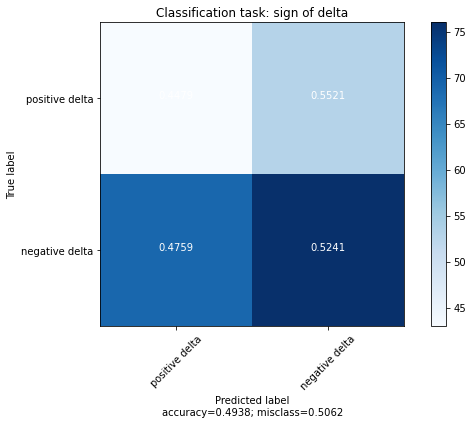

In [499]:
baseline_test = mean_squared_error(z_test_14d, np.full(z_test_14d.shape, np.mean(z_test_14d)), squared=False)
print('Baseline regression RMSE = ',baseline_test)

model_analysis(model_RF, z_test_14d, X_test_14d, 'testing', model_name='HP_TUNED_RF', save_figs=True)

## Redoing the Random Forest HPT but with the corrected feature set that includes past values of z rather than past values of y

In [546]:
# this requires creating different data sets so we'll change our
# data processing methods here

def get_lagged_z(df, z, delay):
    '''take in lagged feature matrix, attach lagged y values'''
    for i in range(delay):
        df['z_'+str(i+1)] = z.shift(i+1)
    return df

def get_timeseries_df_z(df, z, delay):
    '''wrapper method to do both steps in one call'''
    df = get_lagged_df(df, delay)
    df = get_lagged_z(df, z, delay)
    return df

In [550]:
# generating the datasets
X_train_14d_z = get_timeseries_df_z(X_train, z_train, 14)
X_val_14d_z = get_timeseries_df_z(X_val, z_val, 14)
X_test_14d_z = get_timeseries_df_z(X_test, z_test, 14)

# From the check above, will get rid of all non-date features expect for Open_0
cols_to_remv = ['High_0', 'Low_0', 'Close_0', 'Volume_0', 'moving_avg_50_0',
               'moving_avg_100_0', 'Avg_month_temp_0', 'Avg_month_temp_dev_0',
               'CCI_0', 'VIXCLS_0']
X_train_14d_z.drop(columns=cols_to_remv, inplace=True)
X_val_14d_z.drop(columns=cols_to_remv, inplace=True)
X_test_14d_z.drop(columns=cols_to_remv, inplace=True)

*Check alignment with z and delayed z*

In [552]:
X_train_14d_z['z_1']

0            NaN
1            NaN
2     -13.770020
3      -9.449951
4      29.619995
         ...    
748    -0.020020
749    10.610108
750    -1.160156
751     2.080078
752   -23.899903
Name: z_1, Length: 753, dtype: float64

In [549]:
z_train

Adj Close
1   -13.770020
2    -9.449951
3    29.619995
4     9.250000
5     0.550049
..         ...
748  10.610108
749  -1.160156
750   2.080078
751 -23.899903
752 -16.040039

[752 rows x 1 columns]

In [553]:
# drop rows with missing values
X_train_14d_z_dropna = X_train_14d_z.dropna()
X_val_14d_z_dropna = X_val_14d_z.dropna()
X_test_14d_z_dropna = X_test_14d_z.dropna()

In [554]:
z_train_14d_dropna = z_train.loc[X_train_14d_z_dropna.index]
z_val_14d_dropna = z_val.loc[X_val_14d_z_dropna.index]
z_test_14d_dropna = z_test.loc[X_test_14d_z_dropna.index]

### Saving our datasets to file

- "_14d_" indicates the 14-day windowing of the data
- "_z_" indicates that z is used as the target variable (and whose past values are included in the window
- "_dropna" indicates that missing values are dropped

In [567]:
# ... and saving them to our data folder
X_train_14d_z_dropna.to_csv('../data/X_train_14d_z_dropna.csv', index=False)
X_val_14d_z_dropna.to_csv('../data/X_val_14d_z_dropna.csv', index=False)
X_test_14d_z_dropna.to_csv('../data/X_test_14d_z_dropna.csv', index=False)

z_train_14d_dropna.to_csv('../data/z_train_14d_dropna.csv', index=False)
z_val_14d_dropna.to_csv('../data/z_val_14d_dropna.csv', index=False)
z_test_14d_dropna.to_csv('../data/z_test_14d_dropna.csv', index=False)

# ... and the versions with missing values are saved as well because those
# will be used for the XGB model
X_train_14d_z.to_csv('../data/X_train_14d_z.csv', index=False)
X_val_14d_z.to_csv('../data/X_val_14d_z.csv', index=False)
X_test_14d_z.to_csv('../data/X_test_14d_z.csv', index=False)

z_train.to_csv('../data/z_train.csv', index=False)
z_val.to_csv('../data/z_val.csv', index=False)
z_test.to_csv('../data/z_test.csv', index=False)

***Rerunning the hyperparameter tuning to see if the same model comes out***

In [558]:
from sklearn.ensemble import RandomForestRegressor

# we fix the model's random state here
RF_algo = RandomForestRegressor(random_state=42)
param_grid = {'max_depth': [i for i in range(1,50,5)],
               # the max_depth should be smaller or equal than the number of features roughly
               # we'll limit it to 50 because while we have >350 features in the 14-day windowed
               # dataset, ~ 25 of those come from each day, so we expect overfitting far before 350
              'max_features': [0.5,0.6,0.7,0.8,0.9,1.0], 
              # linearly spaced between 0.5 and 1
              'criterion': ['mse','mae']}
HPT_model_RF, HPT_score_RF = ML_pipe_RMSE(X_train_14d_z_dropna,
                            z_train_14d_dropna, 
                            X_val_14d_z_dropna, 
                            z_val_14d_dropna, 
                            RF_algo, 
                            param_grid)
print('Val score: ',HPT_score_RF)

best model parameters: {'criterion': 'mae', 'max_depth': 1, 'max_features': 0.5}
Val score:  26.740423648808008


Baseline regression RMSE =  17.32618206185664
R2 on the training data =  0.021185521580197486
RMSE on the training data =  17.14166746889463


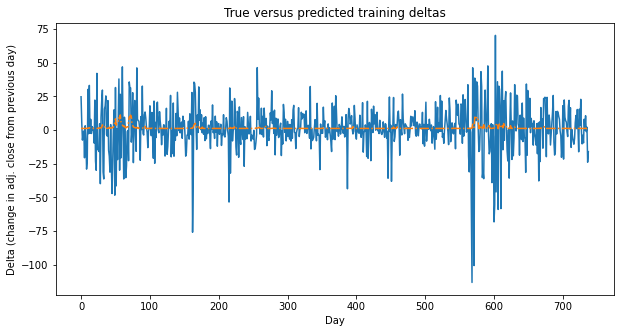

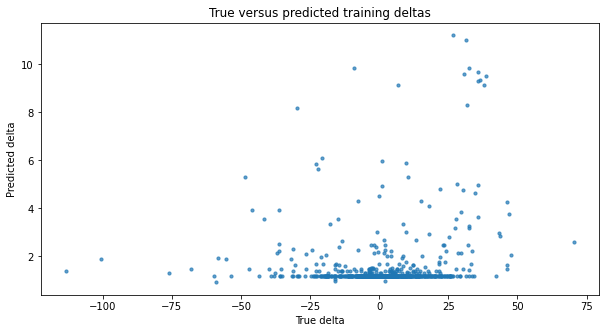

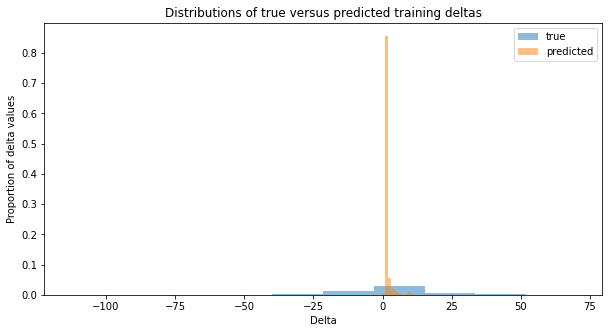

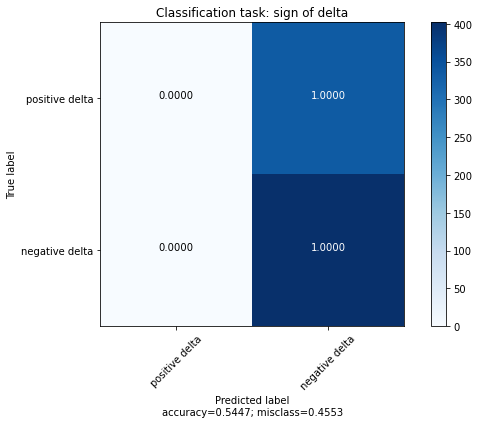

In [559]:
# we'll also show the baseline RMSE for predicting the mean z
baseline_train = mean_squared_error(z_train_14d_dropna, 
                                    np.full(z_train_14d_dropna.shape, np.mean(z_train_14d_dropna)), 
                                    squared=False)
print('Baseline regression RMSE = ',baseline_train)
model_analysis(HPT_model_RF, z_train_14d_dropna, X_train_14d_z_dropna,
               'training', model_name='HPT_RF', save_figs=True)

Baseline regression RMSE =  27.555216656266666
R2 on the validation data =  0.05826457624471826
RMSE on the validation data =  26.740423648808008


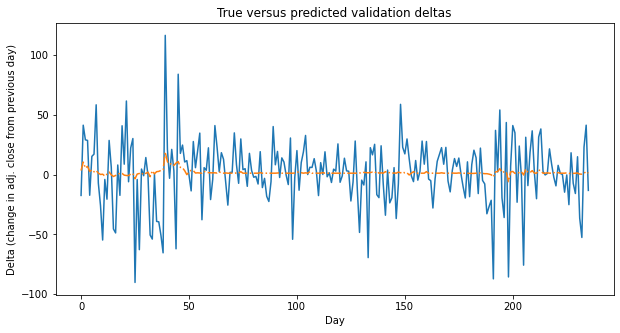

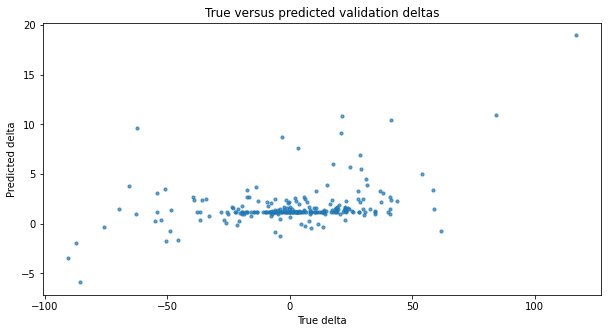

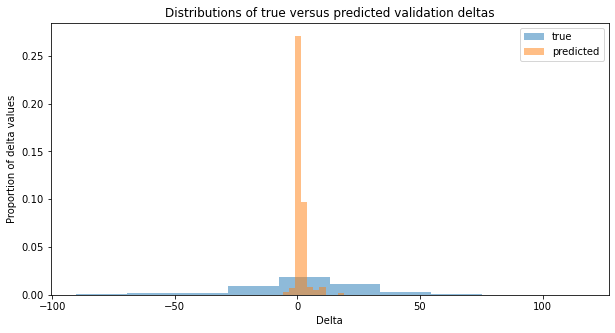

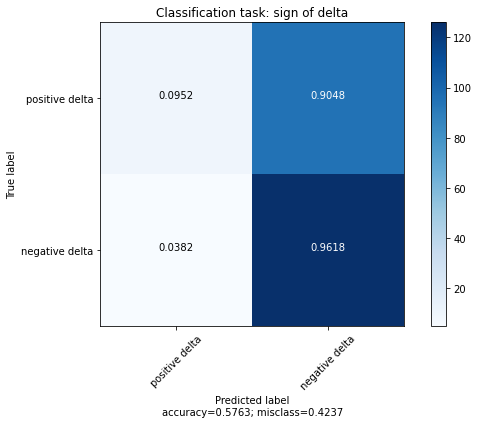

In [560]:
baseline_val = mean_squared_error(z_val_14d_dropna, 
                                    np.full(z_val_14d_dropna.shape, np.mean(z_val_14d_dropna)), 
                                    squared=False)
print('Baseline regression RMSE = ',baseline_val)
model_analysis(HPT_model_RF, z_val_14d_dropna, X_val_14d_z_dropna,
               'validation', model_name='HPT_RF', save_figs=True)

Baseline regression RMSE =  60.529074867933595
R2 on the testing data =  -0.0054933958598921695
RMSE on the testing data =  60.69510225132475


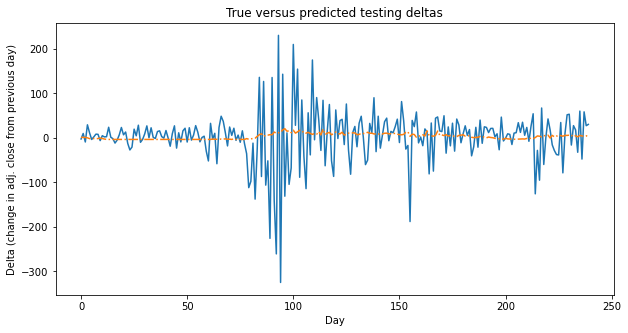

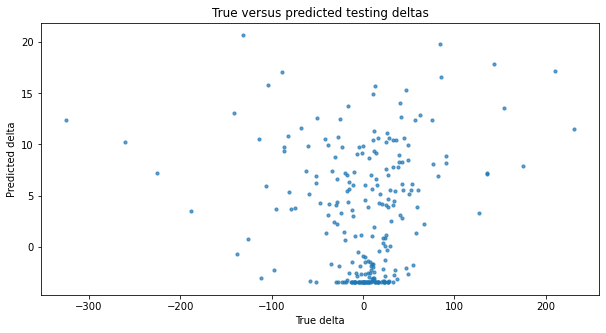

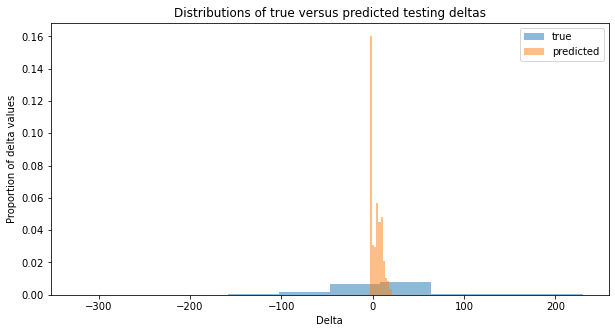

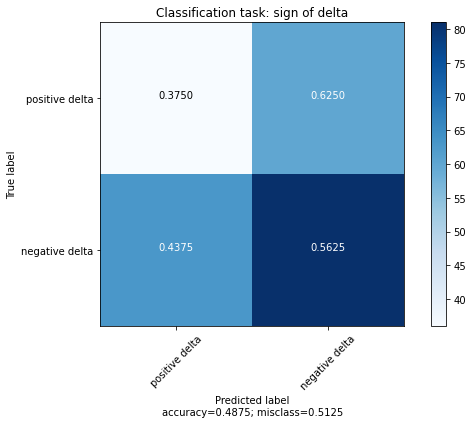

In [561]:
baseline_test = mean_squared_error(z_test_14d_dropna, 
                                    np.full(z_test_14d_dropna.shape, np.mean(z_test_14d_dropna)), 
                                    squared=False)
print('Baseline regression RMSE = ',baseline_test)
model_analysis(HPT_model_RF, z_test_14d_dropna, X_test_14d_z_dropna,
               'testing', model_name='HPT_RF', save_figs=True)

------

### From the above we can see that the hyperparameter tuning process is just optimizing for a model that is as close to the baseline as possible. Here's an example of a random forest set to a greater maximum depth:

In [562]:
rf_reference = RandomForestRegressor(random_state=42, max_depth=30, max_features=0.9, criterion='mae')
rf_reference.fit(X_train_14d_z_dropna, z_train_14d_dropna.values.ravel())

RandomForestRegressor(criterion='mae', max_depth=30, max_features=0.9,
                      random_state=42)

R2 on the training data =  0.8329345706528387
RMSE on the training data =  7.081840956626097


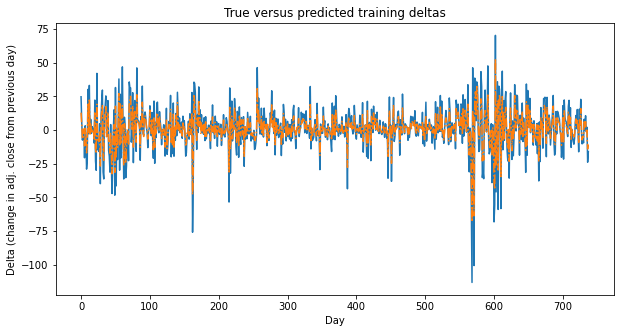

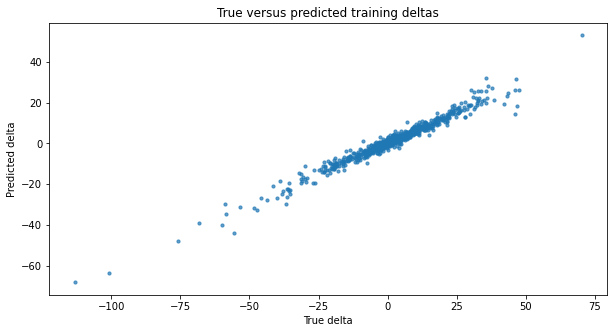

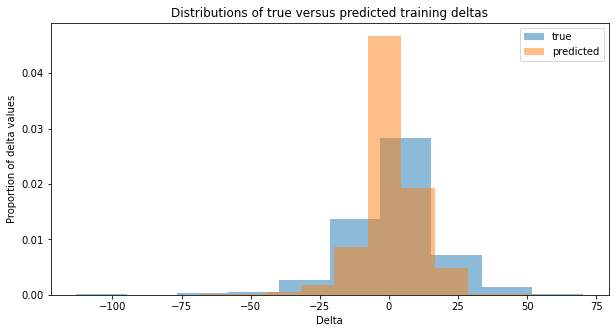

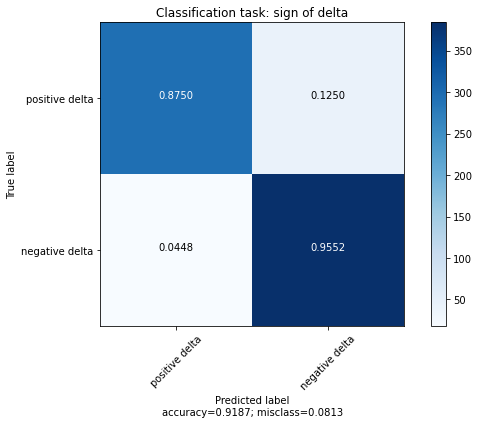

In [563]:
model_analysis(rf_reference, z_train_14d_dropna, X_train_14d_z_dropna,
               'training', model_name='rf_reference', save_figs=True)

R2 on the validation data =  -0.13397541096093724
RMSE on the validation data =  29.343076697403017


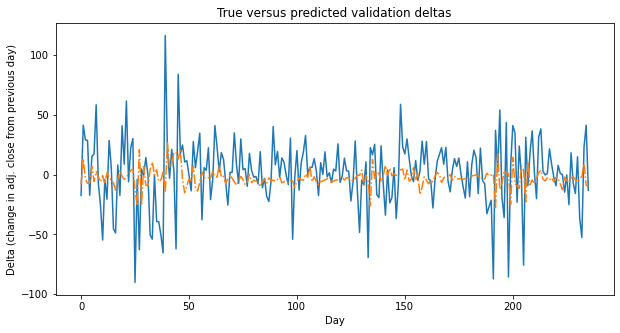

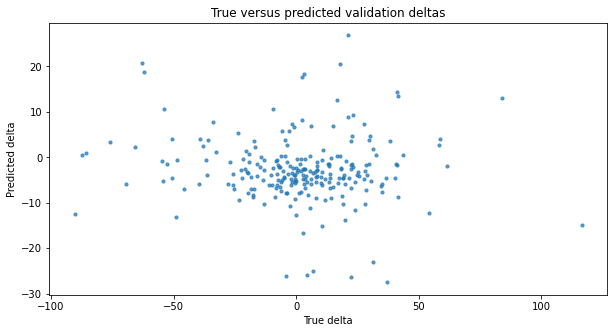

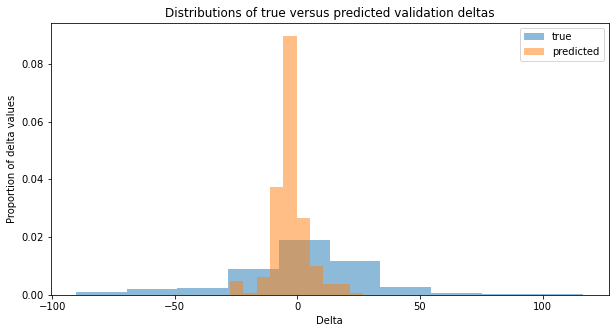

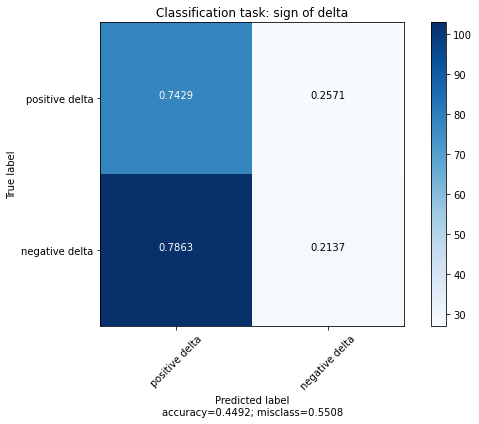

In [564]:
model_analysis(rf_reference, z_val_14d_dropna, X_val_14d_z_dropna,
               'validation', model_name='rf_reference', save_figs=True)

R2 on the testing data =  -0.0010359937146833254
RMSE on the testing data =  60.5604206220935


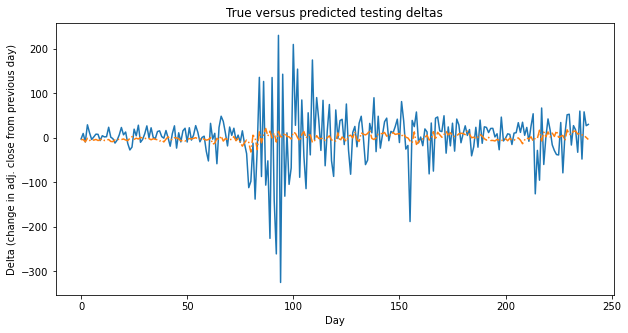

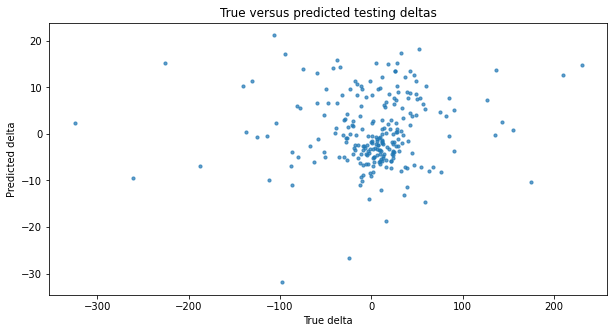

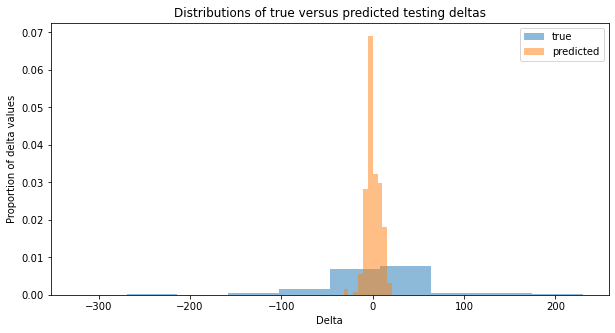

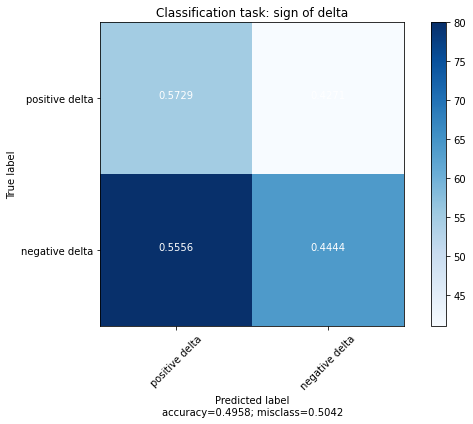

In [566]:
model_analysis(rf_reference, z_test_14d_dropna, X_test_14d_z_dropna,
               'testing', model_name='rf_reference', save_figs=True)

------

## Hyperparameter tuning: SVR

In [568]:
from sklearn.svm import SVR

SVR_algo = SVR()
param_grid = {'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],
             # --> gamma should be logspaced
             'C': [0.1, 1, 10, 100]}
             # ---> and we'll logspace space C from 0.1 to 100
HPT_model_SVR, HPT_score_SVR = ML_pipe_RMSE(X_train_14d_z_dropna,
                            z_train_14d_dropna, 
                            X_val_14d_z_dropna, 
                            z_val_14d_dropna, 
                            SVR_algo, 
                            param_grid)
print('Val score: ',HPT_score_SVR)

best model parameters: {'C': 10, 'gamma': 0.01}
Val score:  21.208453142220044


Baseline regression RMSE =  17.32618206185664
R2 on the training data =  0.5314711609210665
RMSE on the training data =  11.859627202860473


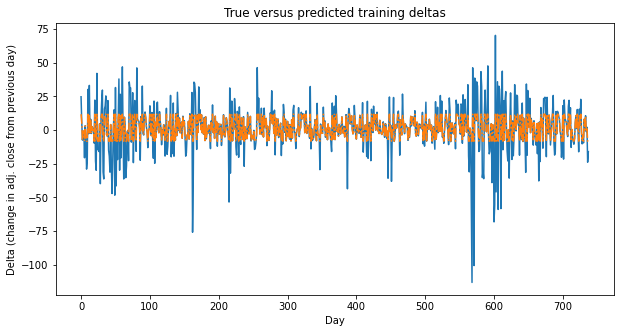

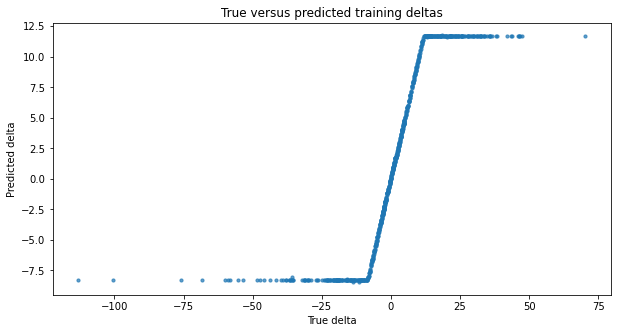

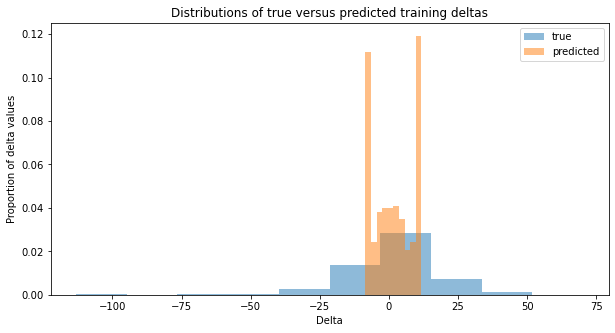

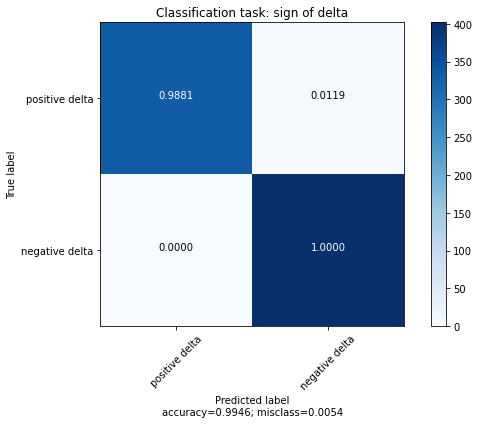

In [569]:
baseline_train = mean_squared_error(z_train_14d_dropna, 
                                    np.full(z_train_14d_dropna.shape, np.mean(z_train_14d_dropna)), 
                                    squared=False)
print('Baseline regression RMSE = ',baseline_train)
model_analysis(HPT_model_SVR, z_train_14d_dropna, X_train_14d_z_dropna, 
               'training', model_name='HPT_SVR', save_figs=True)

Baseline regression RMSE =  27.555216656266666
R2 on the validation data =  0.40760644097111653
RMSE on the validation data =  21.208453142220044


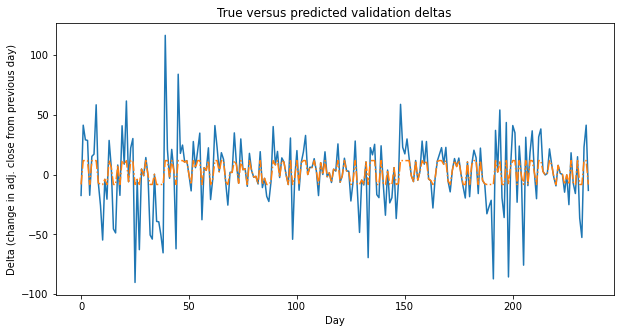

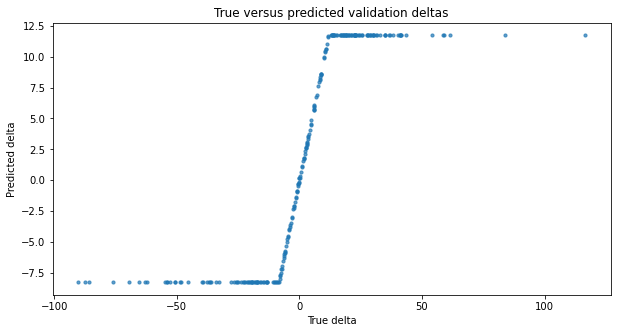

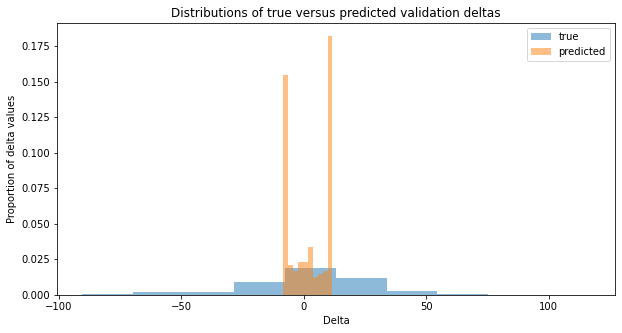

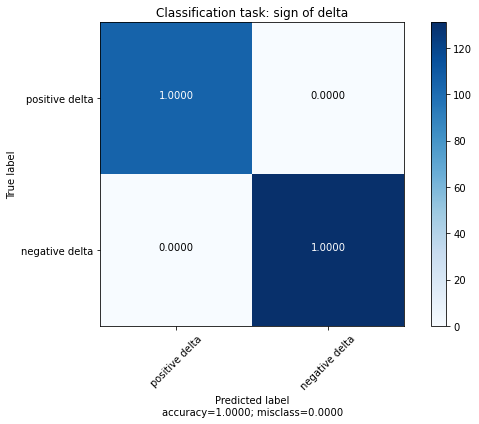

In [570]:
baseline_val = mean_squared_error(z_val_14d_dropna, 
                                    np.full(z_val_14d_dropna.shape, np.mean(z_val_14d_dropna)), 
                                    squared=False)
print('Baseline regression RMSE = ',baseline_val)
model_analysis(HPT_model_SVR, z_val_14d_dropna, X_val_14d_z_dropna, 
               'validation', model_name='HPT_SVR', save_figs=True)

Baseline regression RMSE =  60.529074867933595
R2 on the testing data =  -2.6853979802066164e-06
RMSE on the testing data =  60.52915614020673


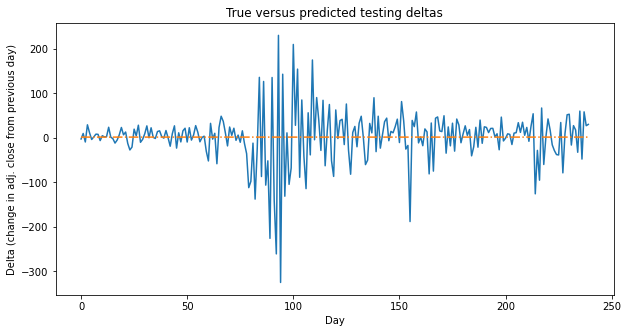

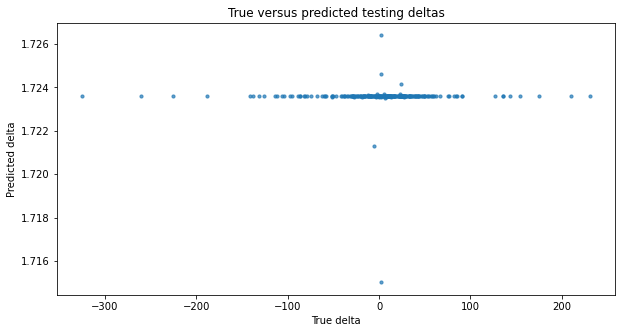

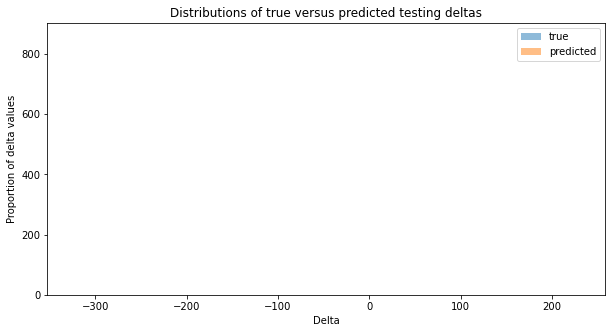

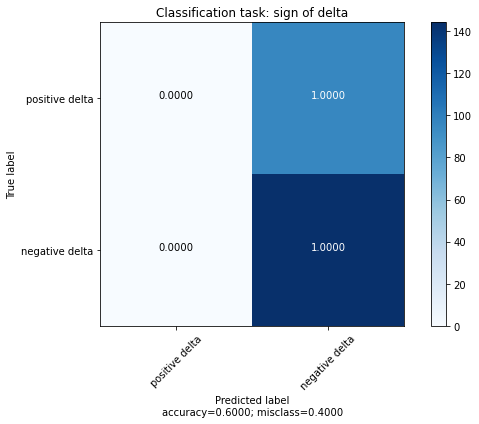

In [571]:
baseline_test = mean_squared_error(z_test_14d_dropna, 
                                    np.full(z_test_14d_dropna.shape, np.mean(z_test_14d_dropna)), 
                                    squared=False)
print('Baseline regression RMSE = ',baseline_test)
model_analysis(HPT_model_SVR, z_test_14d_dropna, X_test_14d_z_dropna, 
               'testing', model_name='HPT_SVR', save_figs=True)

## Hyperparameter tuning: XGB
***We will try it first on the same dataset without missing values (for consistency with the past two methods), then we will try it with the missing values to see if we get any additional power from taking advantage of XGBoost's ability to handle missing values***

In [ ]:
import xgboost

param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [42],
              "missing": [np.nan], 
              "max_depth": [1,3,10,30,100],
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

XGB = xgboost.XGBRegressor()